In [6]:
from regions import DS9Parser, read_ds9
from regions import PixCoord, CirclePixelRegion,RectanglePixelRegion, PolygonPixelRegion,EllipsePixelRegion, PolygonSkyRegion
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import regions
from astropy.table import *
from tqdm import tqdm
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.wcs import WCS
import matplotlib

plt.rc('font', family='serif'), plt.rc('xtick', labelsize=18), plt.rc('ytick', labelsize=18)
plt.rcParams['savefig.dpi'] = 100
plt.rc('text',usetex=True)
matplotlib.rcParams['xtick.direction'] = 'in'
matplotlib.rcParams['ytick.direction'] = 'in'
np.set_printoptions(precision=3)

### comparison of z's and masses

In [7]:
# matching anneya's thibaud's and vincent's catalog in COSMOS
cat_a_name = 'CUT_deep_catalogs/s16a_COSMOS_deep_masterCat.fits'
cat_t_name = 'CUT_deep_catalogs/UV_CLAUDS_HSC_S16A_COSMOS_deep.fits'
cat_v_name = 'clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v6_gal_cut_params.fits'
combined_cat_name = 'CUT_deep_catalogs/cosmos_combined_ATV.fits'
join = '1and2'

# matching cat_a and cat_t
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_a_name + \
                ' in2='+cat_t_name+' find=best join='+join+' matcher=sky params=1.0 values1="RA DEC"' + \
                ' values2="RA DEC" out='+combined_cat_name
print(cmd)

# matching cat_at and cat_v
cmd = 'java -jar stilts.jar tmatch2 in1='+combined_cat_name + \
                ' in2='+cat_v_name+' find=best join='+join+' matcher=sky params=1.0 values1="RA_1 DEC_1"' + \
                ' values2="RA DEC" out='+combined_cat_name
print(cmd)


java -jar stilts.jar tmatch2 in1=CUT_deep_catalogs/s16a_COSMOS_deep_masterCat.fits in2=CUT_deep_catalogs/UV_CLAUDS_HSC_S16A_COSMOS_deep.fits find=best join=1and2 matcher=sky params=1.0 values1="RA DEC" values2="RA DEC" out=CUT_deep_catalogs/cosmos_combined_ATV.fits
java -jar stilts.jar tmatch2 in1=CUT_deep_catalogs/cosmos_combined_ATV.fits in2=clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v6_gal_cut_params.fits find=best join=1and2 matcher=sky params=1.0 values1="RA_1 DEC_1" values2="RA DEC" out=CUT_deep_catalogs/cosmos_combined_ATV.fits


In [86]:
# keep useful parameters / rename
combined_cat = Table.read(combined_cat_name)
useful_params = ['zKDEPeak_1','zKDEMedian_1','ZPHOT_2','Z_BEST_BC03','MASS_MED_1','MASS_MED_2','MASS_MED','OBJ_TYPE','preds_median_1']
combined_cat = combined_cat[useful_params]
combined_cat.rename_column('MASS_MED','MASS_MED_new')
combined_cat.rename_column('zKDEPeak_1','zKDEPeak')
combined_cat.rename_column('zKDEMedian_1','zKDEMedian')
combined_cat.rename_column('ZPHOT_2','ZPHOT')
combined_cat.write(combined_cat_name, overwrite=True) 

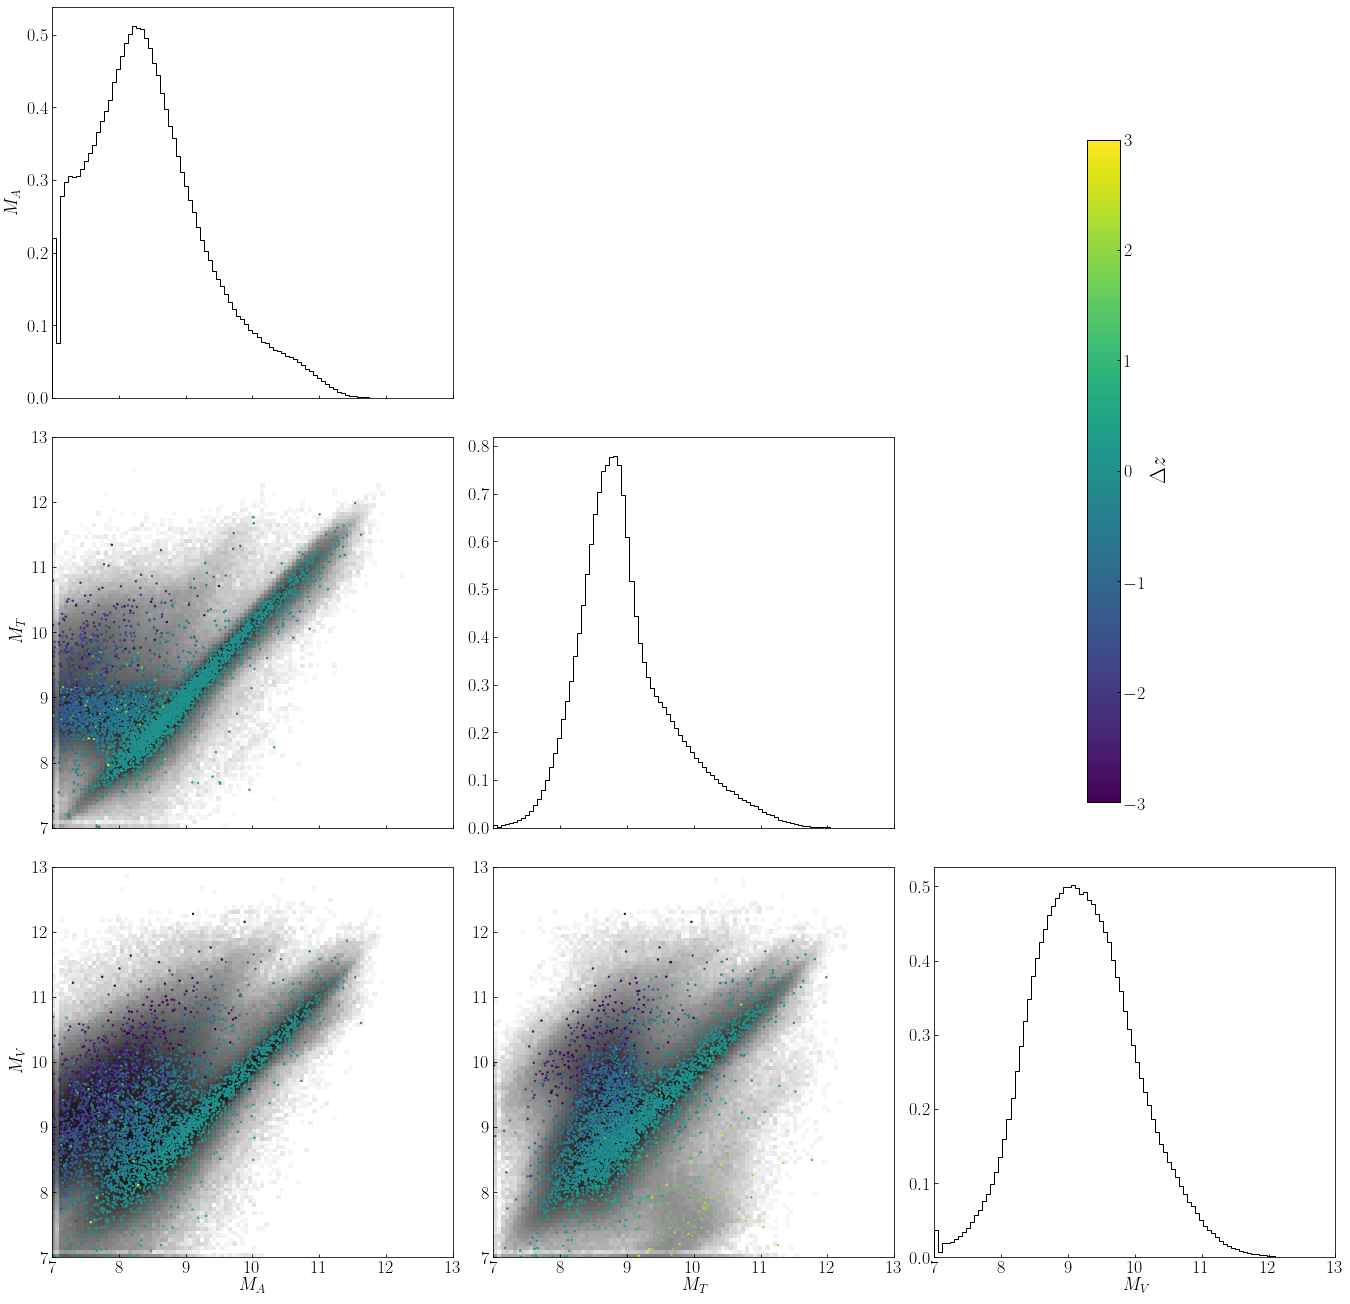

In [87]:
cat = Table.read('CUT_deep_catalogs/cosmos_combined_ATV.fits')

fig, axs = plt.subplots(3, 3, figsize=(23,23),sharex=True)

# _1 from anneya's catalog
# _2 from thibaud's catalog
# _new from vincent's catalog

# galaxy selection
cat = cat[cat['OBJ_TYPE']==0]  # vincent's galaxy selection

# histograms
axs[0][0].hist(cat['MASS_MED_1'], bins=100, range=(7,13),density=True,color='k',histtype='step')
axs[1][1].hist(cat['MASS_MED_2'], bins=100, range=(7,13),density=True,color='k',histtype='step')
axs[2][2].hist(cat['MASS_MED_new'], bins=100, range=(7,13),density=True,color='k',histtype='step')


# correlations
axs[2][0].hist2d(cat['MASS_MED_1'], cat['MASS_MED_new'], bins=100,
                 range=[[7,13],[7,13]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[2][1].hist2d(cat['MASS_MED_2'], cat['MASS_MED_new'], bins=100,
                 range=[[7,13],[7,13]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[1][0].hist2d(cat['MASS_MED_1'], cat['MASS_MED_2'], bins=100,
                 range=[[7,13],[7,13]],norm=mpl.colors.LogNorm(), cmap='Greys')

# delta_z
cat = cat[np.random.randint(low=0,high=len(cat),size=5000)]
delta_z_at = cat['zKDEPeak'] - cat['Z_BEST_BC03']
delta_z_tv = cat['Z_BEST_BC03'] - cat['ZPHOT']
delta_z_av = cat['zKDEPeak'] - cat['ZPHOT']
im = axs[2][0].scatter(cat['MASS_MED_1'], cat['MASS_MED_new'],c=delta_z_av ,s=2,vmin=-3,vmax=3)
axs[2][1].scatter(cat['MASS_MED_2'], cat['MASS_MED_new'],c=delta_z_tv ,s=2,vmin=-3,vmax=3)
axs[1][0].scatter(cat['MASS_MED_1'], cat['MASS_MED_2'],c=delta_z_at ,s=2,vmin=-3,vmax=3)

axs[2][0].set_xlabel(r'$M_A$',fontsize=18)
axs[2][1].set_xlabel(r'$M_T$',fontsize=18)
axs[2][2].set_xlabel(r'$M_V$',fontsize=18)

axs[0][0].set_ylabel(r'$M_A$',fontsize=18)
axs[1][0].set_ylabel(r'$M_T$',fontsize=18)
axs[2][0].set_ylabel(r'$M_V$',fontsize=18)

axs[2][0].set_xlim([7,13])
axs[2][1].set_xlim([7,13])
axs[1][0].set_xlim([7,13])
axs[2][0].set_ylim([7,13])
axs[2][1].set_ylim([7,13])
axs[1][0].set_ylim([7,13])

cb_ax = fig.add_axes([0.75, 0.4, 0.02, 0.4])
cbar = fig.colorbar(im, cax=cb_ax)
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.set_ylabel(r'$\Delta z$',fontsize=22)

fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.1)
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])

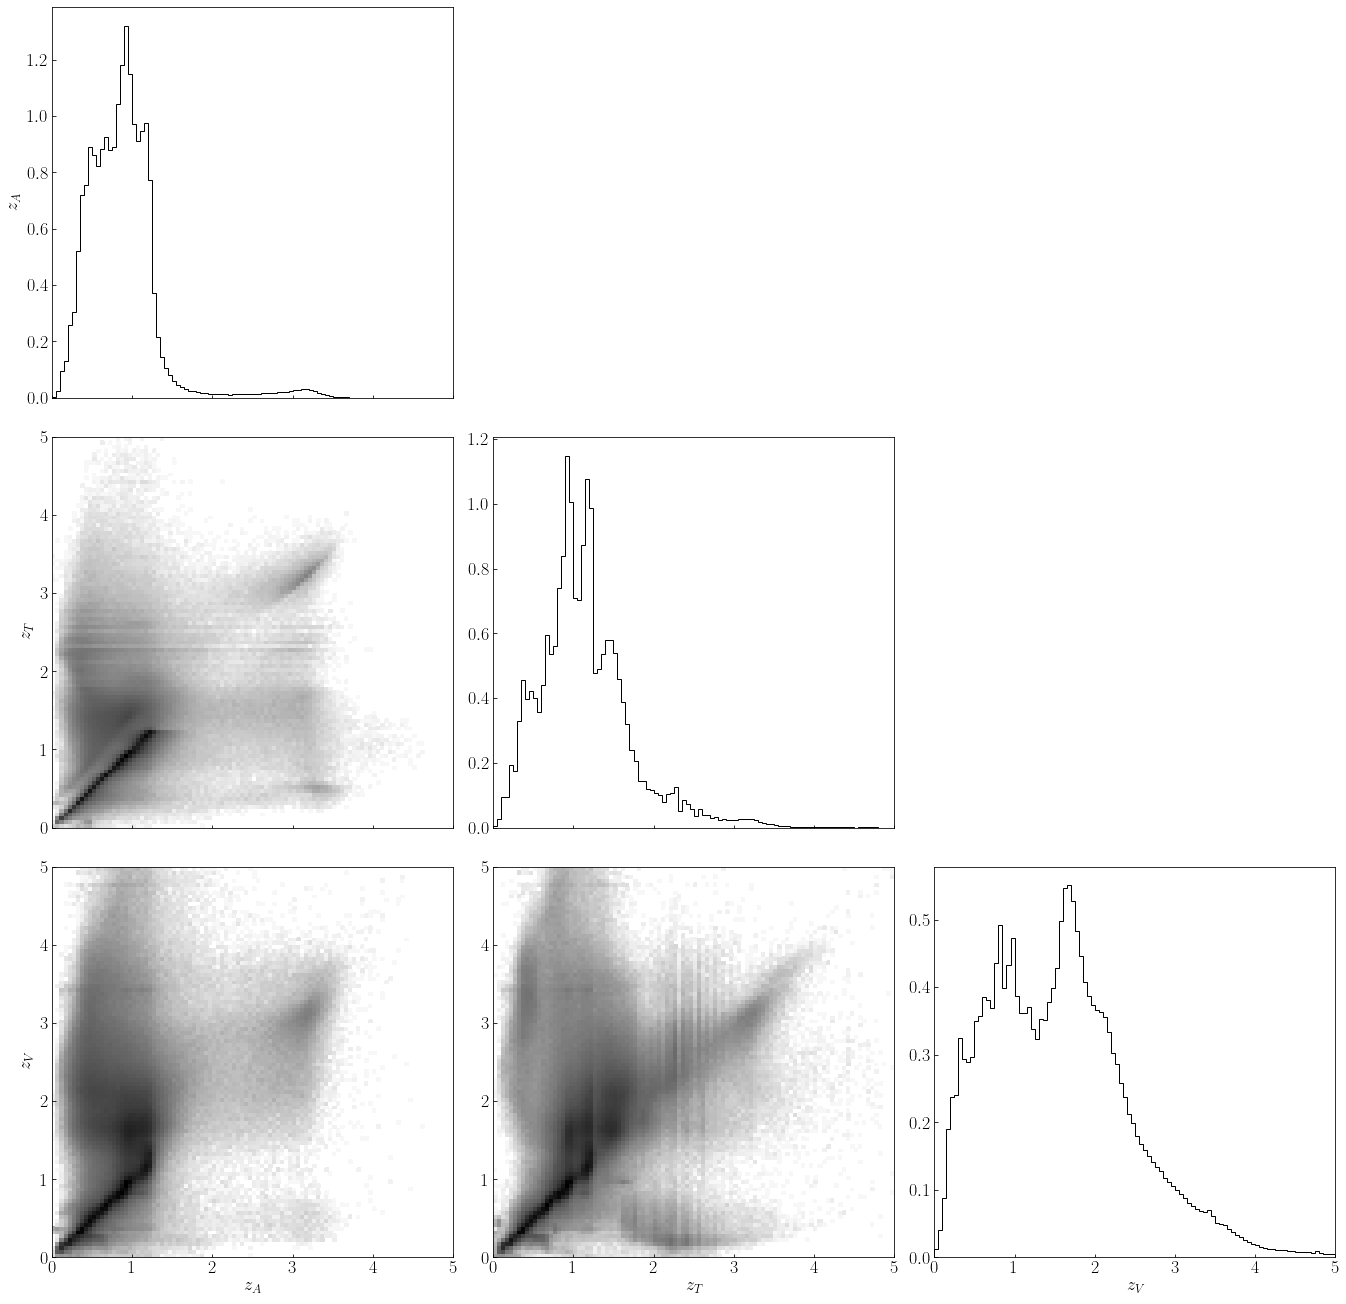

In [89]:
cat = Table.read('CUT_deep_catalogs/cosmos_combined_ATV.fits')
fig, axs = plt.subplots(3, 3, figsize=(23,23),sharex=True)

# histograms
axs[0][0].hist(cat['zKDEMedian'], bins=100, range=(0,5),density=True,color='k',histtype='step')
axs[1][1].hist(cat['Z_BEST_BC03'], bins=100, range=(0,5),density=True,color='k',histtype='step')
axs[2][2].hist(cat['ZPHOT'], bins=100, range=(0,5),density=True,color='k',histtype='step')

# correlations

axs[2][0].hist2d(cat['zKDEMedian'], cat['ZPHOT'], bins=100,
                 range=[[0,5],[0,5]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[2][1].hist2d(cat['Z_BEST_BC03'], cat['ZPHOT'], bins=100,
                 range=[[0,5],[0,5]],norm=mpl.colors.LogNorm(), cmap='Greys')
axs[1][0].hist2d(cat['zKDEMedian'], cat['Z_BEST_BC03'], bins=100,
                 range=[[0,5],[0,5]],norm=mpl.colors.LogNorm(), cmap='Greys')

axs[2][0].set_xlabel(r'$z_A$',fontsize=18)
axs[2][1].set_xlabel(r'$z_T$',fontsize=18)
axs[2][2].set_xlabel(r'$z_V$',fontsize=18)

axs[0][0].set_ylabel(r'$z_A$',fontsize=18)
axs[1][0].set_ylabel(r'$z_T$',fontsize=18)
axs[2][0].set_ylabel(r'$z_V$',fontsize=18)


fig.subplots_adjust(hspace=0.1)
fig.subplots_adjust(wspace=0.1)
fig.delaxes(axs[0][1])
fig.delaxes(axs[0][2])
fig.delaxes(axs[1][2])

### demograhpics on the new catalogs
NUVrK


In [44]:
# field
cat_name = 'COSMOS_deep'

# # 1) Anneya's catalog
# cat_a = Table.read('CUT_deep_catalogs/s16a_'+cat_name+'_masterCat.fits')
# cat_a = cat_a
# cat_a = cat_a[cat_a['inside']==True]
# cat_a_gal = cat_a[cat_a['preds_median']<0.89]
# # cat_a_bright = cat_a_inside[cat_a_inside['i']<26.5]

# # 2) Thibaud's catalog
# cat_t = Table.read('CUT_deep_catalogs/UV_CLAUDS_HSC_S16A_'+cat_name+'.fits')
# cat_t= cat_t
# cat_t_gal = cat_t[cat_t['CLASS']<10]
# # cat_t_bright = cat_t_inside[cat_t_inside['i']<26.5]

# 3) Vincent's catalog
cat_v = Table.read('clauds_cat_v2020/completeness_useful_params_cat/'+cat_name+'_v9_gal_cut_params.fits')
cat_v = cat_v[cat_v['MASK']==0]
cat_v = cat_v[cat_v['inside_u']==True]
cat_v_gal = cat_v[cat_v['OBJ_TYPE'] == 0]
# cat_v_bright = cat_v_inside[cat_v_inside['i']<26.5]

# 4) Vincent's COSMOS_uddd catalog
cat_v_uddd = Table.read('clauds_cat_v2020/COSMOS_UDD_Ugrizy_v3_NOV2020.fits')


## SF/Q classification

In [35]:
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition,mark_inset)
from astropy.cosmology import Planck13
from sklearn.neighbors import KernelDensity
from sklearn import svm
from sklearn.model_selection import GridSearchCV
import pickle
import os

/Users/lejay/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  """Entry point for launching an IPython kernel.


In [36]:
# define the functions

def gv_boundary(color1,z):
    t_l = Planck13.lookback_time(z)  # Planck 2013 lookback time (Gyr)
    color2_1 = 3.272 - 0.029*t_l.value
    color2_2 = 2.25*color1 +2.268 - 0.029*t_l.value
    return np.maximum(color2_1, color2_2)

def gv_boundary_2(color1, ic_1, ic_2, slope):
    nuv_1 = ic_1
    nuv_2 = slope*color1 + ic_2
    return np.maximum(nuv_1, nuv_2)

def fraction_score(cat, ic_1, ic_2, slope, diagram_type='',eval_type='q',verbose=False):
    if diagram_type=='NUVrk':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_Ks']
    elif diagram_type=='NUVrz':
        color1 = cat['MAG_ABS_r'] - cat['MAG_ABS_z']
    else:
        return 1
    delta_gv = cat['MAG_ABS_NUV'] - cat['MAG_ABS_r'] - gv_boundary_2(color1, ic_1, ic_2, slope)
    
    q = delta_gv > 0
    sf = delta_gv < 0
    true_q = cat['CLASS']==0 
    true_sf = cat['CLASS']!=0
    
    if eval_type=='q':
        FP = sum(true_sf*q)  # false positive
        TP = sum(true_q*q)   # true positive
        FN = sum(true_q*sf)  # false negative
        TN = sum(true_sf*sf) # true negative
    else:
        FP = sum(true_q*sf)  # false positive
        TP = sum(true_sf*sf)   # true positive
        FN = sum(true_sf*q)  # false negative
        TN = sum(true_q*q) # true negative
    if verbose:
        print('confusion matrix',FP,TP,FN,TN)
        
    if TP+FP>0:
        fc = FP/(TP+FP)
    else:
        fc=0.99
    
    if TP+FN>0:
        fm = FN/(TP+FN)
    else:
        fm=0.99
    return fc, fm, fc+fm+abs(fc-fm)

def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:,0]
    Z = Z.reshape(xx.shape)
    out = ax.contour(xx, yy, Z, **params)
    return out

# binary selection box parameter search grid
ic_1 = np.linspace(2.8, 3.5, 10)
ic_2 = np.linspace(2.5, 3.3, 13)
slope = np.linspace(1.1, 2.5, 20)
ic_1_mesh, ic_2_mesh, slope_mesh = np.meshgrid(ic_1, ic_2, slope, indexing='ij')
print('search grid size:',len(ic_1_mesh.ravel()))

search grid size: 2600


#### prepare/match the catalogs
##### v3 COSMOS 6band in uddd

In [112]:
# match between COSMOS_6band (only in uddd region) and COSMOS2015 (or COSMOS2020) (1" match)
cat_v_uddd_name = 'clauds_cat_v2020/COSMOS_UDD_Ugrizy_v3_NOV2020.fits' # only 6-band photometry
cat_2020_name = '/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits'
combined_cat_name = 'COSMOS2020_Laigle_Vincent_uddd_added.fits'

# matching
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_2020_name + ' in2='+cat_v_uddd_name+' find=best join=1and2 matcher=sky params=1.0 values1="alpha delta" values2="RA DEC" out='+combined_cat_name
print(cmd)
print('')
print('RUN AT TERMINAL!')

java -jar stilts.jar tmatch2 in1=/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits in2=clauds_cat_v2020/COSMOS_UDD_Ugrizy_v3_NOV2020.fits find=best join=1and2 matcher=sky params=1.0 values1="alpha delta" values2="RA DEC" out=COSMOS2020_Laigle_Vincent_uddd_added.fits

RUN AT TERMINAL!


In [113]:
# keep useful parameters in COSMOS2020_added catalog
combined_cat_name = 'COSMOS2020_Laigle_Vincent_uddd_added.fits'
cat=Table.read(combined_cat_name)
useful_params = ['RA','DEC','Z_ML','zPDF','mass_med_1','MASS_MED_2','SSFR_MED_2','r','i','z','CLASS',
                'MU','MR','MZ','MK','MNUV','mask','type','MAG_ABS_NUV','MAG_ABS_r','MAG_ABS_z','MAG_ABS_Ks']

cat = cat[useful_params]
cat.rename_column('mass_med_1','MASS_MED_COSMOS')
cat.rename_column('MASS_MED_2','MASS_MED')
cat.rename_column('SSFR_MED_2','SSFR_MED')
cat.rename_column('zPDF','ZPDF')

print(combined_cat_name)
cat.write(combined_cat_name, overwrite=True)

COSMOS2020_Laigle_Vincent_uddd_added.fits


##### v10 COSMOS inside_j

In [62]:
# match between COSMOS_6band (v10, inside j) and COSMOS2015 (or COSMOS2020) (1" match)
cat_v10_inside_j_name = 'clauds_cat_v2020/COSMOS_deep_v10_gal_cut_params_inside_j.fits' # with IR data
cat_2020_name = '/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits'
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v10_added_inside_j.fits'
# matching
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_2020_name + \
                ' in2='+cat_v10_inside_j_name+' find=best join=1and2 matcher=sky params=1.0 values1="alpha delta"' + \
                ' values2="RA DEC" out='+combined_cat_name
print(cmd)
print('')
print('RUN AT TERMINAL!')

java -jar stilts.jar tmatch2 in1=/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits in2=clauds_cat_v2020/COSMOS_deep_v10_gal_cut_params_inside_j.fits find=best join=1and2 matcher=sky params=1.0 values1="alpha delta" values2="RA DEC" out=COSMOS2020_Laigle_Vincent_v10_added_inside_j.fits

RUN AT TERMINAL!


In [63]:
# keep useful parameters in COSMOS2020_added catalog
# _1 from COSMOS2020
# _2 from Vincent's catalog
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v10_added_inside_j.fits'
cat=Table.read(combined_cat_name)
useful_params = ['RA','DEC','Z_ML','zPDF','mass_med_1','MASS_MED_2','SSFR_MED_2','r','i','z','J','CLASS',
                'MU','MR','MZ','MK','MNUV','mask_1','type','MAG_ABS_NUV','MAG_ABS_r','MAG_ABS_z','MAG_ABS_Ks']

cat = cat[useful_params]
cat = cat[cat['J']>0]
cat.rename_column('mass_med_1','MASS_MED_COSMOS')
cat.rename_column('mask_1','mask')
cat.rename_column('MASS_MED_2','MASS_MED')
cat.rename_column('SSFR_MED_2','SSFR_MED')
cat.rename_column('zPDF','ZPDF')

print(combined_cat_name)
cat.write(combined_cat_name, overwrite=True)

['Id_1', 'alpha', 'delta', 'zBEST', 'zPDF', 'mask_1', 'type', 'mass_med_1', 'SFR_med', 'sSFR_med_1', 'MNUV', 'MU', 'MR', 'MZ', 'MJ', 'MK', 'CLASS', 'ID_2', 'RA', 'DEC', 'TRACT', 'PATCH', 'MASK_2', 'inside_j', 'inside_hsc', 'inside_u', 'u', 'uS', 'g', 'r', 'i', 'z', 'y', 'Yv', 'J', 'H', 'Ks', 'MAG_ABS_NUV', 'MAG_ABS_r', 'MAG_ABS_i', 'MAG_ABS_z', 'MAG_ABS_J', 'MAG_ABS_H', 'MAG_ABS_Ks', 'NBAND_USED', 'Z_ML', 'ZPHOT', 'MASS_MED_2', 'MASS_INF', 'MASS_SUP', 'SSFR_MED_2', 'OBJ_TYPE', 'STAR_FORMING', 'MAG_ABS_r_6B', 'MAG_ABS_i_6B', 'MAG_ABS_z_6B', 'MAG_ABS_y_6B', 'MAG_ABS_Ks_6B', 'MAG_ABS_NUV_6B', 'Z_ML_6B', 'MASS_MED_6B', 'MASS_INF_6B', 'MASS_SUP_6B', 'SSFR_MED_6B', 'Separation']
COSMOS2020_Laigle_Vincent_v10_added_inside_j.fits


##### v10 COSMOS 6band

In [66]:
# match between COSMOS_6band (v10, not inside j) and COSMOS2020 (1" match)
cat_v10_6B_name = 'clauds_cat_v2020/COSMOS_deep_v10_gal_cut_params_6B.fits' # only 6-band photometry
cat_2020_name = '/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits'
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v10_added_6B.fits'
# matching
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_2020_name + \
                ' in2='+cat_v10_6B_name+' find=best join=1and2 matcher=sky params=1.0 values1="alpha delta"' + \
                ' values2="RA DEC" out='+combined_cat_name
print(cmd)
print('')
print('RUN AT TERMINAL!')

java -jar stilts.jar tmatch2 in1=/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits in2=clauds_cat_v2020/COSMOS_deep_v10_gal_cut_params_6B.fits find=best join=1and2 matcher=sky params=1.0 values1="alpha delta" values2="RA DEC" out=COSMOS2020_Laigle_Vincent_v10_added_6B.fits

RUN AT TERMINAL!


In [73]:
# keep useful parameters in COSMOS2020_added catalog
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v10_added_6B.fits'
cat=Table.read(combined_cat_name)
useful_params = ['RA','DEC','Z_ML_6B','zPDF','mass_med_1','MASS_MED_2','SSFR_MED_2','STAR_FORMING','r','i','z','J','CLASS',
                'MU','MR','MZ','MK','MNUV','type','mask_1','MAG_ABS_NUV_6B','MAG_ABS_r_6B','MAG_ABS_z_6B','MAG_ABS_Ks_6B']

cat = cat[useful_params]
cat.rename_column('mass_med_1','MASS_MED_COSMOS')
cat.rename_column('MASS_MED_2','MASS_MED')
cat.rename_column('SSFR_MED_2','SSFR_MED')
cat.rename_column('zPDF','ZPDF')
cat.rename_column('MAG_ABS_NUV_6B','MAG_ABS_NUV')
cat.rename_column('MAG_ABS_r_6B','MAG_ABS_r')
cat.rename_column('MAG_ABS_z_6B','MAG_ABS_z')
cat.rename_column('MAG_ABS_Ks_6B','MAG_ABS_Ks')
cat.rename_column('mask_1','mask')
cat.rename_column('Z_ML_6B','Z_ML')
print(combined_cat_name)
cat.write(combined_cat_name, overwrite=True)

COSMOS2020_Laigle_Vincent_v10_added_6B.fits


v11 in COSMOS (geometry flags from v9, same detection as in v9)

In [19]:
# match between COSMOS_6band (v11) and COSMOS2020 (1" match)
cat_v11_6B_name = '/Volumes/LejaySSD/v11_cats/COSMOS_deep_v11_6B_v211224.fits' # only 6-band photometry
cat_2020_name = '/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits'
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v11_added_6B.fits'
# matching
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_2020_name + \
                ' in2='+cat_v11_6B_name+' find=best join=1and2 matcher=sky params=1.0 values1="alpha delta"' + \
                ' values2="RA DEC" out='+combined_cat_name
print(cmd)
print('')
print('RUN AT TERMINAL!')

java -jar stilts.jar tmatch2 in1=/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits in2=/Volumes/LejaySSD/v11_cats/COSMOS_deep_v11_6B_v211224.fits find=best join=1and2 matcher=sky params=1.0 values1="alpha delta" values2="RA DEC" out=COSMOS2020_Laigle_Vincent_v11_added_6B.fits

RUN AT TERMINAL!


In [31]:
# keep useful parameters in COSMOS2020_added catalog
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v11_added_6B.fits'
cat=Table.read(combined_cat_name)
useful_params = ['RA','DEC','Z_BEST','zPDF','mass_med_1','MASS_MED_2','SSFR_MED_2','r_MAG_OBS','i_MAG_OBS','z_MAG_OBS','J_MAG_OBS','CLASS',
                'MU','MR','MZ','MK','MNUV','type','mask_1','NUV_MAG_ABS','r_MAG_ABS','z_MAG_ABS','K_MAG_ABS']

cat = cat[useful_params]
cat.rename_column('mass_med_1','MASS_MED_COSMOS')
cat.rename_column('MASS_MED_2','MASS_MED')
cat.rename_column('SSFR_MED_2','SSFR_MED')
cat.rename_column('NUV_MAG_ABS','MAG_ABS_NUV')
cat.rename_column('r_MAG_OBS','r')
cat.rename_column('i_MAG_OBS','i')
cat.rename_column('z_MAG_OBS','z')
cat.rename_column('J_MAG_OBS','J')
cat.rename_column('r_MAG_ABS','MAG_ABS_r')
cat.rename_column('z_MAG_ABS','MAG_ABS_z')
cat.rename_column('K_MAG_ABS','MAG_ABS_Ks')
cat.rename_column('zPDF','ZPDF')
cat.rename_column('mask_1','mask')
print(combined_cat_name)
cat.write(combined_cat_name, overwrite=True)

COSMOS2020_Laigle_Vincent_v11_added_6B.fits


##### v9 COSMOS all-band

In [22]:
# match between COSMOS (v9) and COSMOS2020 (1" match)
cat_v9_name = 'clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params.fits'
cat_2020_name = '/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits'
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v9_added.fits'
# matching
cmd = 'java -jar stilts.jar tmatch2 in1='+cat_2020_name + \
                ' in2='+cat_v9_name+' find=best join=1and2 matcher=sky params=1.0 values1="alpha delta"' + \
                ' values2="RA DEC" out='+combined_cat_name
print(cmd)
print('')
print('RUN AT TERMINAL!')

java -jar stilts.jar tmatch2 in1=/Volumes/LejaySSD/COSMOS2020/photoz_cosmos2020_lephare_classic_v1.8_trim_SfqAdded.fits in2=clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params.fits find=best join=1and2 matcher=sky params=1.0 values1="alpha delta" values2="RA DEC" out=COSMOS2020_Laigle_Vincent_v9_added.fits

RUN AT TERMINAL!


In [23]:
# keep useful parameters in COSMOS2020_added catalog
combined_cat_name = 'COSMOS2020_Laigle_Vincent_v9_added.fits'
cat=Table.read(combined_cat_name)
useful_params = ['RA','DEC','Z_ML','zPDF','mass_med_1','MASS_MED_2','SSFR_MED_2','r','i','z','J','CLASS',
                'MU','MR','MZ','MK','MNUV','type','mask_1','sfProb_nuvrk','sfProb_nuvrz']

cat = cat[useful_params]
cat.rename_column('mass_med_1','MASS_MED_COSMOS')
cat.rename_column('MASS_MED_2','MASS_MED')
cat.rename_column('SSFR_MED_2','SSFR_MED')
cat.rename_column('zPDF','ZPDF')
cat.rename_column('mask_1','mask')
print(combined_cat_name)
cat.write(combined_cat_name, overwrite=True)

COSMOS2020_Laigle_Vincent_v9_added.fits


#### load training catalog for sf/q classification

In [33]:
# _1 from COSMOS2020
# _2 from CLAUDS/HSC COSMOS (6band or inside_j)

# cat_lv_added_2020 = Table.read('COSMOS2020_Laigle_Vincent_uddd_added.fits')  
# params_save_path = 'sfq_trained_params_old_6band_v3/'  # path to save the SVM and binary selection box parameters

# cat_lv_added_2020 = Table.read('COSMOS2020_Laigle_Vincent_v10_added_inside_j.fits') 
# params_save_path = 'sfq_trained_params_inside_j_v10/'

# cat_lv_added_2020 = Table.read('COSMOS2020_Laigle_Vincent_v10_added_6B.fits')  
# params_save_path = 'sfq_trained_params_new_6band_v10/'

cat_lv_added_2020 = Table.read('COSMOS2020_Laigle_Vincent_v11_added_6B.fits') 
params_save_path = 'sfq_trained_params_6band_v11/'

cat_lv_added_2020 = cat_lv_added_2020[cat_lv_added_2020['MU']>-99]
cat_lv_added_2020 = cat_lv_added_2020[cat_lv_added_2020['MR']>-99]
cat_lv_added_2020 = cat_lv_added_2020[cat_lv_added_2020['MZ']>-99]
cat_lv_added_2020 = cat_lv_added_2020[cat_lv_added_2020['MK']>-99]
cat_lv_added_2020 = cat_lv_added_2020[cat_lv_added_2020['MNUV']>-99]

# COSMOS2020 selection
cat_lv_added_2020 = cat_lv_added_2020[cat_lv_added_2020['mask']==0]  # unmasked
cat_lv_gal = cat_lv_added_2020[cat_lv_added_2020['type']==0]  # galaxy
print(params_save_path,len(cat_lv_gal))

/Users/lejay/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:991: RuntimeWarning: invalid value encountered in greater
  result = getattr(super(), op)(other)


sfq_trained_params_6band_v11/ 602662


Text(0, 0.5, '$z_{ML}$')

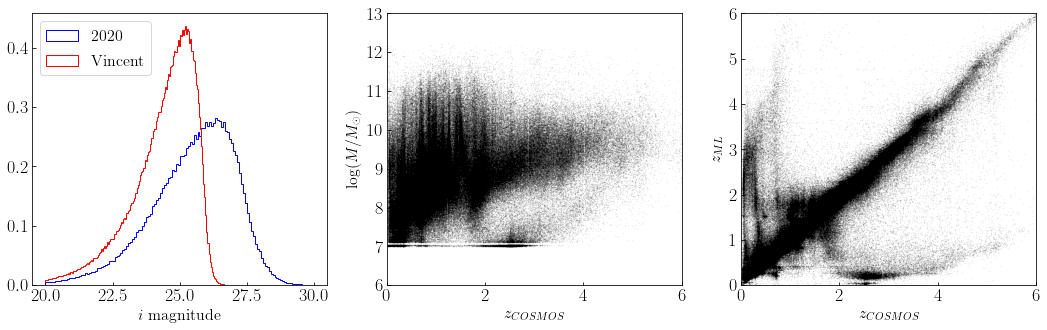

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(18,5))

# magnitude distribution
axs[0].hist(cat_lv_gal['i'],range=(20,30),bins='scott',color='b',histtype='step',density=True,label='2020')
axs[0].hist(cat_v_gal['i'],range=(20,30),bins='scott',color='r',histtype='step',density=True,label='Vincent')
axs[0].legend(fontsize=16,loc='upper left')
axs[0].set_xlabel('$i$ magnitude', fontsize=16)

# mass vs z plot
axs[1].scatter(cat_lv_gal['ZPDF'],cat_lv_gal['MASS_MED'],s=0.1,c='k',alpha=0.1)
axs[1].set_xlim([0,6])
axs[1].set_ylim([6,13])
axs[1].set_xlabel('$z_{COSMOS}$', fontsize=16)
axs[1].set_ylabel('$\log(M/M_\odot)$', fontsize=16)

# z_ml vs zpdf plot
axs[2].scatter(cat_lv_gal['ZPDF'],cat_lv_gal['Z_ML'],s=0.1,c='k',alpha=0.1)
axs[2].set_xlim([0,6])
axs[2].set_ylim([0,6])
axs[2].set_xlabel('$z_{COSMOS}$', fontsize=16)
axs[2].set_ylabel('$z_{ML}$', fontsize=16)

### Train the SVM classifiers / selection box

#### train the binary selection boxes

In [19]:
zs = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
mass_limits = [9.5, 10, 10.5 ,11.0, 13.0]
sfq_type = 'NUVrk'

fc_list = []
fm_list = []
best_box = []
for i in range(24):
    row = i // 6
    col = i % 6
    
    z = zs[col]  
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_ML']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']<mass_limits[row+1]]
    print(sfq_type,z,mass_limits[row],mass_limits[row+1])
    
    fcs = []
    fms = []
    scores = []
    for i in range(len(ic_1_mesh.ravel())):
        fc,fm,score = fraction_score(cat_lv_gal_z, ic_1_mesh.ravel()[i], ic_2_mesh.ravel()[i], slope_mesh.ravel()[i],diagram_type=sfq_type)
        if score >= 0 and score<999.:
            scores.append(round(score,5))
        else:
            scores.append(999.)
        
        if fc>=0 and fm>=0 and fc<1 and fm<1:
            fcs.append(fc)
            fms.append(fm)
        else:
            fcs.append(0.99)
            fms.append(0.99) 
            
    # best parameters
    best_id = np.argmin(np.array(scores))
    ic_1,ic_2,slope = ic_1_mesh.ravel()[best_id], ic_2_mesh.ravel()[best_id], slope_mesh.ravel()[best_id]
    best_box.append([ic_1,ic_2,slope])
    print(row,col,best_id,[ic_1,ic_2,slope])
    
    fc_list.append(fcs[best_id])
    fm_list.append(fms[best_id])
    print(' ')
    
np.save('best_select_box_'+sfq_type+'.npy',np.array(best_box))


NUVrk 0.4 9.5 10
0 0 1578 [3.422222222222222, 2.5666666666666664, 1.4285714285714286]
 
NUVrk 0.6 9.5 10
0 1 1771 [3.5, 2.5666666666666664, 1.1428571428571428]
 
NUVrk 0.8 9.5 10
0 2 0 [2.8, 2.5, 1.0]
 
NUVrk 1.0 9.5 10
0 3 195 [2.8777777777777778, 2.5, 1.0]
 


IndexError: list index out of range

#### train the SVM classifiers

In [45]:
zs = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
mass_limits = [9.5,10,10.5,11.0,13.0]
sfq_type='NUVrk'
print(sfq_type)

auc_list = []
for i in range(24):
    row = i // 6
    col = i % 6
    
    z = zs[col]    
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_ML']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']<mass_limits[row+1]]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['Z_ML']-cat_lv_gal_z['ZPDF'])<0.15]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['MASS_MED']-cat_lv_gal_z['MASS_MED_COSMOS'])<0.25]
    
    # construct input and labels for SVM
    if sfq_type == 'NUVrk':
        color1 = cat_lv_gal_z['MAG_ABS_r'] - cat_lv_gal_z['MAG_ABS_Ks']
    elif sfq_type == 'NUVrz':
        color1 = cat_lv_gal_z['MAG_ABS_r'] - cat_lv_gal_z['MAG_ABS_z']
        
    nuvr = cat_lv_gal_z['MAG_ABS_NUV'] - cat_lv_gal_z['MAG_ABS_r']
    x=np.c_[np.array(color1),np.array(nuvr)]  # nuv r k colors as inputs
    y=cat_lv_gal_z['CLASS']==0                # COSMOS2015 training labels
    
    # remove outliers (in q sample)
    cat_lv_gal_z_q = cat_lv_gal_z[y]
    cat_lv_gal_z_sf = cat_lv_gal_z[~y]
    if sfq_type == 'NUVrk':
        color1_q = cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_Ks']
    elif sfq_type == 'NUVrz':
        color1_q = cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_z']
        
    nuvr_q = cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r']
    ocs = svm.OneClassSVM(nu=0.25, gamma=0.35)
    ocs.fit(np.c_[color1_q,nuvr_q])
    get_outlier = ocs.predict(np.c_[color1_q,nuvr_q])
    cat_lv_gal_z_q = cat_lv_gal_z_q[get_outlier]
    cat_lv_gal_z = vstack([cat_lv_gal_z_q,cat_lv_gal_z_sf])
    
    # 5-fold CV for best hyperparameter gamma and C
    svm_cv=GridSearchCV(svm.SVC(kernel='rbf'),{'gamma': np.linspace(0.1, 0.3, 50), 'C' : np.linspace(0.02,0.5,50)}, 
                    scoring={'AUC': 'roc_auc'}, refit='AUC', cv = 5, return_train_score=True)
    
    random_ids = np.random.randint(low=0,high=len(cat_lv_gal_z),size=100)
    svm_cv.fit(x[random_ids],y[random_ids])
    gamma = svm_cv.best_params_['gamma']
    C = svm_cv.best_params_['C']
    print('gamma=%.3f, C=%.3f, mean AUC of best model: %.3f' % (gamma,C,svm_cv.best_score_))
    
    # train the SVM model
    clf = svm.SVC(kernel='rbf', gamma=gamma, C=C,  probability=True)   # the svm classifier
    clf.fit(x, y)

    # save the SVM estimator through pickle
    pkl_filename = 'pickle_svm_'+sfq_type+'_'+str(row)+'_'+str(col)+'.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)
    

NUVrk
gamma=0.100, C=0.020, mean AUC of best model: 0.981
gamma=0.100, C=0.020, mean AUC of best model: 0.984
gamma=0.190, C=0.020, mean AUC of best model: 0.965
gamma=0.227, C=0.020, mean AUC of best model: 0.961
gamma=0.100, C=0.020, mean AUC of best model: 1.000
gamma=0.100, C=0.020, mean AUC of best model: 0.989
gamma=0.100, C=0.020, mean AUC of best model: 0.965
gamma=0.100, C=0.020, mean AUC of best model: 0.912
gamma=0.300, C=0.304, mean AUC of best model: 0.917
gamma=0.247, C=0.167, mean AUC of best model: 0.950
gamma=0.100, C=0.020, mean AUC of best model: 0.945
gamma=0.300, C=0.461, mean AUC of best model: 0.955
gamma=0.296, C=0.490, mean AUC of best model: 0.818
gamma=0.100, C=0.020, mean AUC of best model: 0.973
gamma=0.100, C=0.020, mean AUC of best model: 0.861
gamma=0.300, C=0.353, mean AUC of best model: 0.982
gamma=0.284, C=0.108, mean AUC of best model: 0.821
gamma=0.100, C=0.020, mean AUC of best model: 0.943
gamma=0.100, C=0.020, mean AUC of best model: 1.000
gamma=

### NUVrK selection

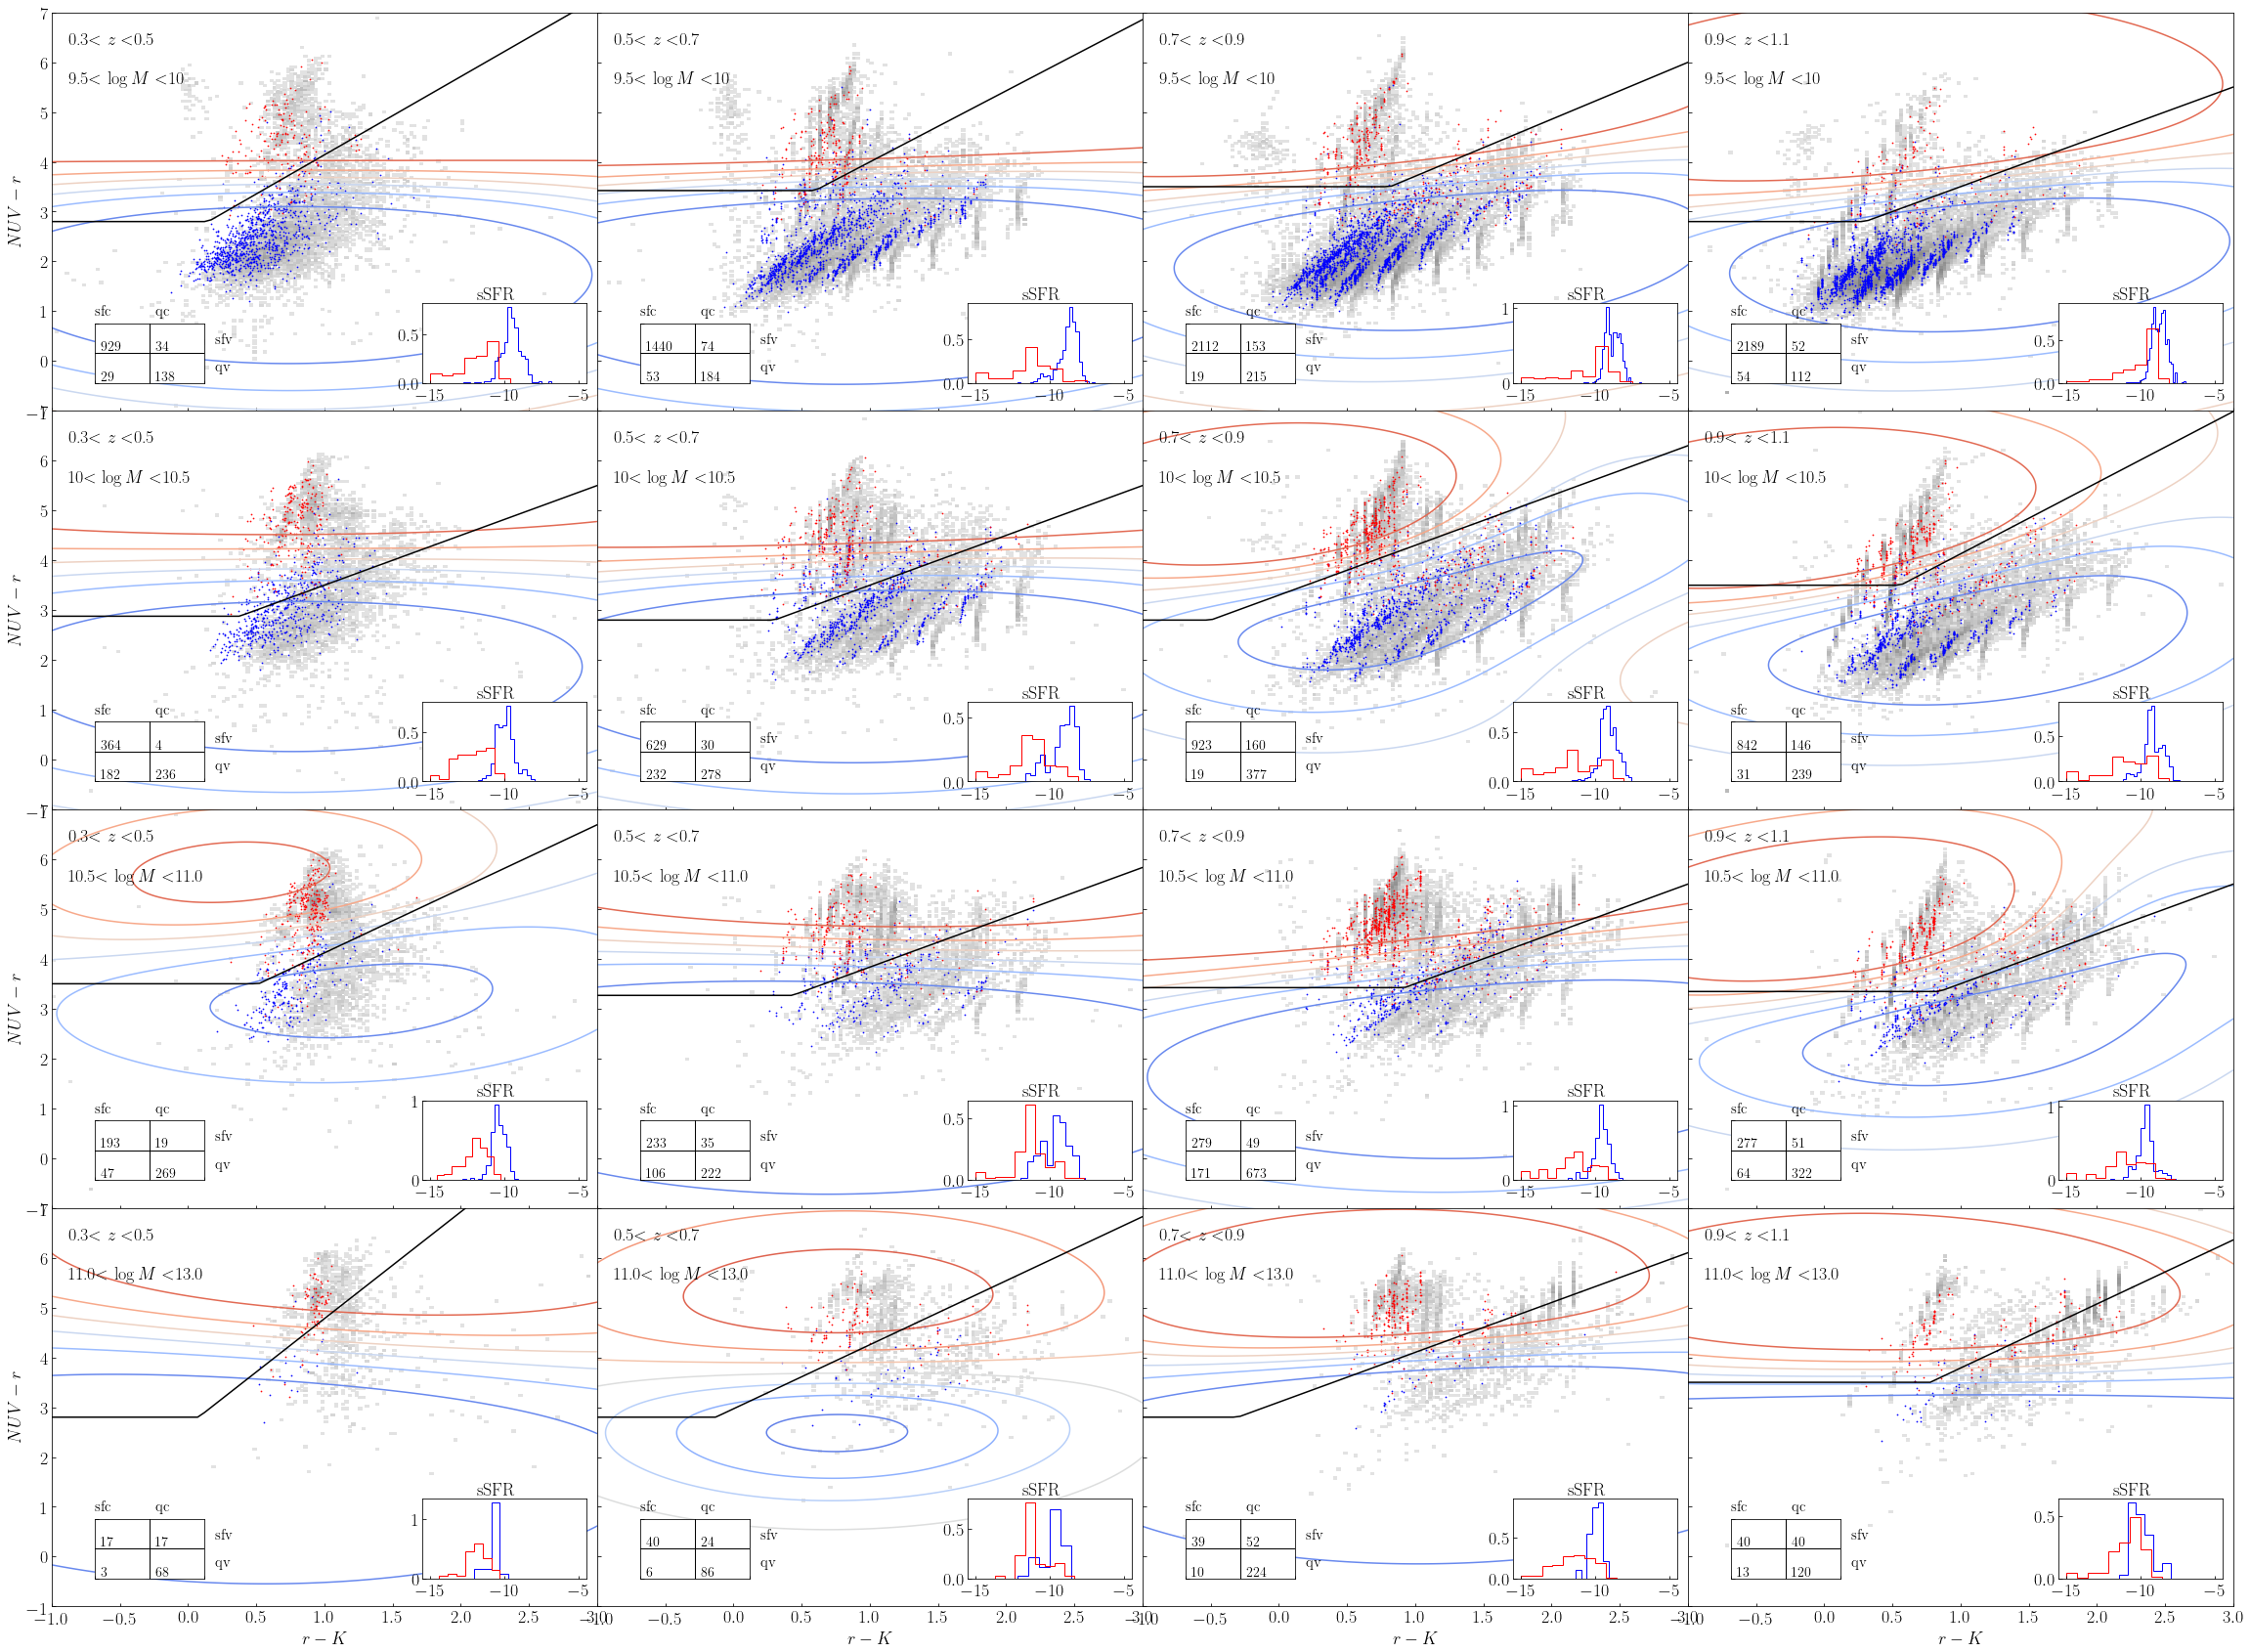

In [13]:
zs = [0.4, 0.6, 0.8, 1.0]
mass_limits = [9.5,10,10.5,11.0,13.0]
fig, axs = plt.subplots(len(mass_limits)-1, len(zs), figsize=(40,30),sharex=True, sharey=True)
inset_type = 'ssfr'
selection_type = 'mass_split' # mass_split or mass_all
if selection_type == 'mass_split':
    best_box = np.load('best_select_box_NUVrk.npy')
else:
    best_box = np.load('best_select_box_one_mass_bin_NUVrk.npy')

fc_list = []
fm_list = []
for i in range(16):
    row = i // len(zs)
    col = i % len(zs)
    z = zs[col]
    
    # (from cosmos2020 matched catalog) select only consistent z/m objects
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_ML']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']>mass_limits[row]]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']<mass_limits[row+1]]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['Z_ML']-cat_lv_gal_z['ZPDF'])<0.15]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['MASS_MED']-cat_lv_gal_z['MASS_MED_COSMOS'])<0.25]
    
    # load the whole catalog 
    cat_v4_gal_z = cat_v_gal[abs(cat_v_gal['Z_ML']-z)<0.1]
    cat_v4_gal_z = cat_v4_gal_z[cat_v4_gal_z['MASS_MED']>mass_limits[row]]
    cat_v4_gal_z = cat_v4_gal_z[cat_v4_gal_z['MASS_MED']<mass_limits[row+1]]
    axs[row][col].hist2d(cat_v4_gal_z['MAG_ABS_r'] - cat_v4_gal_z['MAG_ABS_Ks'], 
                         cat_v4_gal_z['MAG_ABS_NUV'] - cat_v4_gal_z['MAG_ABS_r'],
                         bins=200,range=[[-2,3],[-2,7]], vmin=0.1, vmax=10000,
                         norm=mpl.colors.LogNorm(), cmap='Greys')

    # NUVrK of training sample with COSMOS2020 classification
    cat_lv_gal_z_sf = cat_lv_gal_z[cat_lv_gal_z['CLASS']==1]  #sf
    cat_lv_gal_z_q = cat_lv_gal_z[cat_lv_gal_z['CLASS']==0]  #q
    axs[row][col].scatter(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_Ks'], 
                          cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'],
                         s=0.5,c='b')
    axs[row][col].scatter(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_Ks'], 
                          cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'],
                         s=0.5,c='r')
    rk_sf = np.array(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_Ks'])
    rk_q = np.array(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_Ks']) 
    if selection_type == 'mass_split':
        delta_gv_sf = cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r']-gv_boundary_2(rk_sf,best_box[i][0],best_box[i][1],best_box[i][2])
        delta_gv_q = cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r']-gv_boundary_2(rk_q,best_box[i][0],best_box[i][1],best_box[i][2])
    else:
        delta_gv_sf = cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r']-gv_boundary_2(rk_sf,best_box[col][0],best_box[col][1],best_box[col][2])
        delta_gv_q = cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r']-gv_boundary_2(rk_q,best_box[col][0],best_box[col][1],best_box[col][2])
    
    # inset 1: delta_GV or sSFR
    ax_insert = axs[row][col].inset_axes([0.68, 0.07, 0.3, 0.2])
    if inset_type == 'dgv':   # Delta_GV but seprated by Laigle+2016 NUVrK classification
        ax_insert.hist(delta_gv_sf,range=(-2,2),bins='scott',histtype='step',color='b',density=True)
        ax_insert.hist(delta_gv_q,range=(-2,2),bins='scott',histtype='step',color='r',density=True)
        axs[row][col].annotate('$\Delta$GV',xy=([0.78,0.28]),xycoords='axes fraction',fontsize=18)
    elif inset_type == 'ssfr':   # ssfr seprated by Laigle+2016 NUVrK classification
        ax_insert.hist(cat_lv_gal_z_sf['SSFR_MED'],range=(-15,-5),bins='scott',histtype='step',color='b',density=True)
        ax_insert.hist(cat_lv_gal_z_q['SSFR_MED'],range=(-15,-5),bins='scott',histtype='step',color='r',density=True)
        axs[row][col].annotate('sSFR',xy=([0.78,0.28]),xycoords='axes fraction',fontsize=18)
    
    # plot settings
    axs[row][col].annotate(str(round(z-0.1,1))+"$<z<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate(str(mass_limits[row])+"$<\log M<$"+str(mass_limits[row+1]),xy=([0.03,0.82]),xycoords='axes fraction',fontsize=18)
    axs[3][col].set_xlabel(r'$r-K$',fontsize=18)
    axs[row][0].set_ylabel(r'$NUV-r$',fontsize=18)
    axs[row][col].set_xlim([-1,3])
    axs[row][col].set_ylim([-1,7])
    
    ###### SF/Q classification in NUVrK ########
    # draw the binary selection boundary
    rk_draw = np.linspace(-2,3,100)
    if selection_type == 'mass_split':
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[i][0],best_box[i][1],best_box[i][2])
    else:
        nuv_draw_mid = gv_boundary_2(rk_draw,best_box[col][0],best_box[col][1],best_box[col][2])
    axs[row][col].plot(rk_draw, nuv_draw_mid, color='k')
    
    # Load trained SVM model from file and draw contours
    if selection_type == 'mass_split':
        with open('pickle_svm_NUVrk_'+str(row)+'_'+str(col)+'.pkl', 'rb') as file:
            clf_load = pickle.load(file)
    else:
        with open('pickle_svm_z_NUVrk_'+str(col)+'.pkl', 'rb') as file:
            clf_load = pickle.load(file)
            
    xx, yy = make_meshgrid(np.linspace(-1,3,100), np.linspace(-1,7,100))
    plot_contours(axs[row][col], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
    
    #### contingency table / confusion matrix (inset plot 2) ######
    # [clauds_hsc_class]_[cosmos_class]
    # q=P sf=N
    sf_sf = len(cat_lv_gal_z_sf[delta_gv_sf<0])  # TN
    q_q = len(cat_lv_gal_z_q[delta_gv_q>0])      # TP
    sf_q = len(cat_lv_gal_z_q[delta_gv_q<0])     # FP
    q_sf = len(cat_lv_gal_z_sf[delta_gv_sf>0])   # FN
    fc = sf_q/(q_q+sf_q)
    fm = q_sf/(q_q+q_sf)
    fc_list.append(fc)
    fm_list.append(fm)
    
    axs[row][col].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('sfv',xy=([0.3,0.17]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qv',xy=([0.3,0.1]),xycoords='axes fraction',fontsize=15)
    
    # inset table
    ax_insert2 = axs[row][col].inset_axes([0.08, 0.07, 0.2, 0.15])
    ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
    ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
    ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
    ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
    ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
    ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
    ax_insert2.set_xlim([-1,1])
    ax_insert2.set_ylim([-1,1])
    ax_insert2.set_yticklabels([])
    ax_insert2.set_xticklabels([])
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('/Users/lejay/Desktop/NUVrK.png',dpi=100)
plt.show()


### NUVrz selection

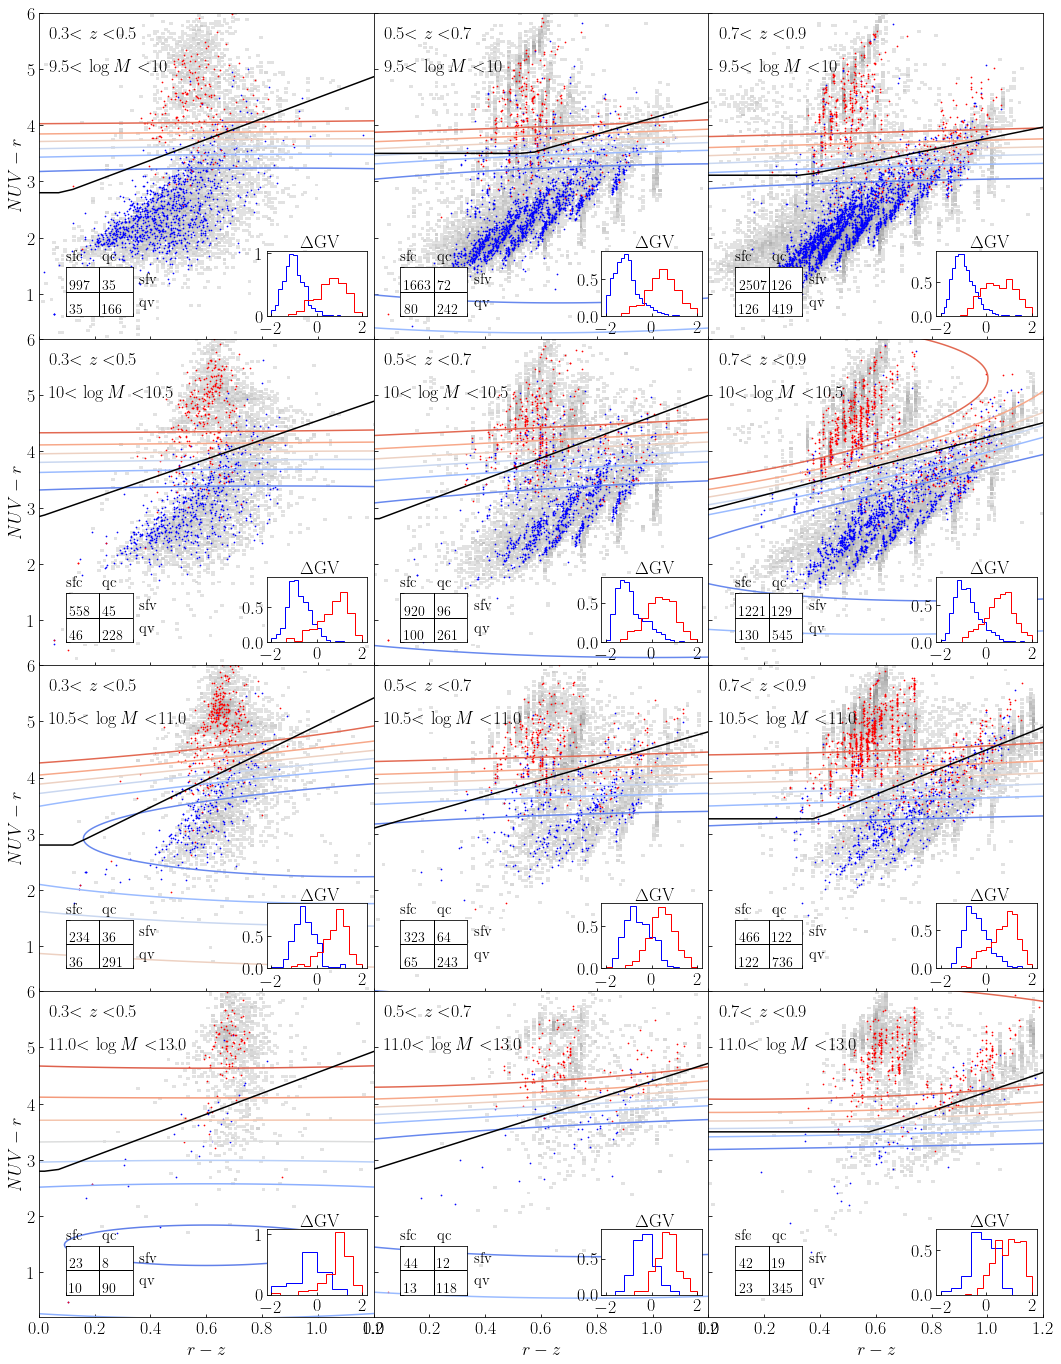

In [109]:
fig, axs = plt.subplots(4, 3, figsize=(18,24),sharex=True, sharey=True)
zs = [0.4, 0.6, 0.8]
mass_limits = [9.5,10,10.5,11.0,13.0]
best_box = np.load('best_select_box_NUVrz.npy')

fc_list = []
fm_list = []
for i in range(12):
    row = i // 3
    col = i % 3
    
    z = zs[col]    
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_ML']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']>mass_limits[row]]  
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']<mass_limits[row+1]]
    
    # load the whole catalog 
    cat_v4_gal_z = cat_v_gal[abs(cat_v_gal['Z_ML']-z)<0.1]
    cat_v4_gal_z = cat_v4_gal_z[cat_v4_gal_z['MASS_MED']>mass_limits[row]]
    cat_v4_gal_z = cat_v4_gal_z[cat_v4_gal_z['MASS_MED']<mass_limits[row+1]]
    axs[row][col].hist2d(cat_v4_gal_z['MAG_ABS_r'] - cat_v4_gal_z['MAG_ABS_z'], 
                         cat_v4_gal_z['MAG_ABS_NUV'] - cat_v4_gal_z['MAG_ABS_r'],
                         bins=200,range=[[0,2],[-1,6]], vmin=0.1, vmax=10000,
                         norm=mpl.colors.LogNorm(), cmap='Greys')

    
    # COSMOS2020 NUVrJ classification
    cat_lv_gal_z_sf = cat_lv_gal_z[cat_lv_gal_z['CLASS']==1]  #sf
    cat_lv_gal_z_q = cat_lv_gal_z[cat_lv_gal_z['CLASS']==0]  #q
    
    # NUVrz but with color-coding from Laigle+2016 NUVrK classification
    axs[row][col].scatter(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_z'], 
                          cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'],
                         s=0.5,c='b')
    axs[row][col].scatter(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_z'], 
                          cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'],
                         s=0.5,c='r')
    
    # Delta_GV but seprated by COSMOS2020 NUVrz classification 
    rz_sfc = np.array(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_z'])
    rz_qc = np.array(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_z'])
    ur_sfc = np.array(cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'])
    ur_qc = np.array(cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'])
    delta_gv_sf = cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r']-gv_boundary_2(rz_sfc,best_box[i][0],best_box[i][1],best_box[i][2])
    delta_gv_q = cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r']-gv_boundary_2(rz_qc,best_box[i][0],best_box[i][1],best_box[i][2])
    
    ax_insert = axs[row][col].inset_axes([0.68, 0.07, 0.3, 0.2])
    ax_insert.hist(delta_gv_sf,range=(-2,2),bins='scott',histtype='step',color='b',density=True)
    ax_insert.hist(delta_gv_q,range=(-2,2),bins='scott',histtype='step',color='r',density=True)
    axs[row][col].annotate(str(round(z-0.1,1))+"$<z<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate(str(mass_limits[row])+"$<\log M<$"+str(mass_limits[row+1]),xy=([0.03,0.82]),xycoords='axes fraction',fontsize=18)
    axs[row][col].annotate('$\Delta$GV',xy=([0.78,0.28]),xycoords='axes fraction',fontsize=18)
    
    ###### SF/Q classification in NUVrK ########
    # draw the binary selection boundary
    rz_draw = np.linspace(-2,3,100)
    nuv_draw_mid = gv_boundary_2(rz_draw,best_box[i][0],best_box[i][1],best_box[i][2])
    axs[row][col].plot(rk_draw, nuv_draw_mid, color='k')

    # Load trained SVM model from file and draw contours
    with open('pickle_svm_NUVrz_'+str(row)+'_'+str(col)+'.pkl', 'rb') as file:
        clf_load = pickle.load(file)
    xx, yy = make_meshgrid(np.linspace(-1,3,100), np.linspace(-1,7,100))
    plot_contours(axs[row][col], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
    
    # contingency table (inset plot 2)
    # clauds_hsc_class _ cosmos_class
    sf_sf = len(cat_lv_gal_z_sf[delta_gv_sf<0])
    q_q = len(cat_lv_gal_z_q[delta_gv_q>0])
    sf_q = len(cat_lv_gal_z_q[delta_gv_q<0])
    q_sf = len(cat_lv_gal_z_sf[delta_gv_sf>0])
    
    fc = sf_q/(q_q+sf_q)
    fm = q_sf/(q_q+q_sf)
    fc_list.append(fc)
    fm_list.append(fm)
    
    ax_insert2 = axs[row][col].inset_axes([0.08, 0.07, 0.2, 0.15])
    axs[row][col].annotate('sfc',xy=([0.08,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qc',xy=([0.19,0.24]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('sfv',xy=([0.3,0.17]),xycoords='axes fraction',fontsize=15)
    axs[row][col].annotate('qv',xy=([0.3,0.1]),xycoords='axes fraction',fontsize=15)
    
    ax_insert2.annotate(str(sf_sf),xy=([-0.9,0.1]),fontsize=14)
    ax_insert2.annotate(str(sf_q),xy=([0.1,0.1]),fontsize=14)
    ax_insert2.annotate(str(q_sf),xy=([-0.9,-0.9]),fontsize=14)
    ax_insert2.annotate(str(q_q),xy=([0.1,-0.9]),fontsize=14)
    ax_insert2.set_xlim([-1,1])
    ax_insert2.set_ylim([-1,1])
    ax_insert2.set_yticklabels([])
    ax_insert2.set_xticklabels([])
    ax_insert2.axvline(ymin=-1,ymax=1,x=0,color='k',linewidth=1)
    ax_insert2.axhline(xmin=-1,xmax=1,y=0,color='k',linewidth=1)
    
    axs[3][col].set_xlabel(r'$r-z$',fontsize=18)
    axs[row][0].set_ylabel(r'$NUV-r$',fontsize=18)
    axs[row][col].set_xlim([0.0,1.2])
    axs[row][col].set_ylim([0.2,6.])
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)

plt.savefig('/Users/lejay/Desktop/NUVrz.pdf')
plt.show()


In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(4,6),sharex=True, sharey=True)
sfq_type='NUVrz'
f_list = fc_list.copy()

zs = [0.4, 0.6, 0.8]
mass_limts = [9.5, 10, 10.5 ,11.0, 13.0]
mass_centers = mass_limits[:-1] + np.diff(mass_limits)/2
z,m=np.meshgrid(zs, mass_centers)

# plot
im = plt.scatter (z.ravel(), m.ravel(), c=f_list,s=2000)

# print actual number
for i in range(12):
    z = zs[i % 3]
    mass = mass_centers[i // 3]
    plt.annotate(round(f_list[i],3),(z-0.05,mass-0.05),fontsize=16)

plt.annotate(sfq_type+', Q',(0.5,11.2),fontsize=16)
plt.annotate('Binary Box',(0.45,11.4),fontsize=16)

# colorbar
cb_ax = fig.add_axes([0.91, 0.3, 0.05, 0.4])
cbar = fig.colorbar(im, cax=cb_ax)
cbar.ax.set_ylabel(r'Contamination Fraction',fontsize=22)

#### A Single Mass Bin (M>9.5)

cat_lv_gal_z from matching between COSMOS2020 and Vincent's COSMOS 6-band photometry

In [50]:
# train SVM and binary selection box

zs = [0.2, 0.4, 0.6, 0.8, 1.0, 1.2]
sfq_type='NUVrz'
best_box = []
print('saving params at:',params_save_path)
print('')
for i in range(6):
    z = zs[i]
    try:
        cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    except KeyError:
        cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_ML']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']>9.5]
    
    # construct input and labels for SVM
    if sfq_type=='NUVrk':
        color1 = cat_lv_gal_z['MAG_ABS_r'] - cat_lv_gal_z['MAG_ABS_Ks']
    elif sfq_type=='NUVrz':
        color1 = cat_lv_gal_z['MAG_ABS_r'] - cat_lv_gal_z['MAG_ABS_z']
        
    nuvr = cat_lv_gal_z['MAG_ABS_NUV'] - cat_lv_gal_z['MAG_ABS_r']
    x=np.c_[np.array(color1),np.array(nuvr)]  # nuv r k colors as inputs
    y=cat_lv_gal_z['CLASS']==0                # COSMOS2020 training labels
    
    # 5-fold CV (cross-validation) for best hyperparameter gamma and C
    svm_cv=GridSearchCV(svm.SVC(kernel='rbf'),{'gamma': np.linspace(0.1, 0.3, 50), 'C' : np.linspace(0.02,0.5,50)}, 
                    scoring={'AUC': 'roc_auc'}, refit='AUC', cv = 5, return_train_score=True)
    random_ids = np.random.randint(low=0, high=len(cat_lv_gal_z), size=100)
    svm_cv.fit(x[random_ids],y[random_ids])
    gamma = svm_cv.best_params_['gamma']
    C = svm_cv.best_params_['C']
    print(z,'gamma=%.3f, C=%.3f, mean AUC of best model: %.3f' % (gamma,C,svm_cv.best_score_))
    
    # train the SVM model
    clf = svm.SVC(kernel='rbf', gamma=gamma, C=C,  probability=True)   # the svm classifier
    clf.fit(x, y)

    # save the SVM estimator through pickle
    pkl_filename = params_save_path+'pickle_svm_z_'+sfq_type+'_'+str(i)+'.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)
        
    # train the binary selection box
    scores = []
    fcs = []
    fms = []
    for i in range(len(ic_1_mesh.ravel())):
        fc, fm, score = fraction_score(cat_lv_gal_z, ic_1_mesh.ravel()[i], ic_2_mesh.ravel()[i], slope_mesh.ravel()[i], diagram_type=sfq_type)
        fcs.append(fc)
        fms.append(fm)
        if score >= 0:
            scores.append(score)
        else:
            scores.append(999.)
    
    best_id = np.argmin(np.array(scores))
    ic_1,ic_2,slope = ic_1_mesh.ravel()[best_id], ic_2_mesh.ravel()[best_id], slope_mesh.ravel()[best_id]
    best_box.append([ic_1,ic_2,slope])
    print('best selection box:',[ic_1,ic_2,slope])
    print(' ')

    np.save(params_save_path+'best_select_box_one_mass_bin_'+sfq_type+'.npy',np.array(best_box))
    

saving params at: sfq_trained_params_6band_v11/

0.2 gamma=0.296, C=0.461, mean AUC of best model: 0.983
best selection box: [2.8, 2.966666666666667, 2.5]
 
0.4 gamma=0.296, C=0.098, mean AUC of best model: 0.980
best selection box: [2.8, 2.6333333333333333, 2.5]
 
0.6 gamma=0.100, C=0.020, mean AUC of best model: 0.937
best selection box: [3.422222222222222, 2.5666666666666664, 2.4263157894736844]
 
0.8 gamma=0.100, C=0.020, mean AUC of best model: 0.896
best selection box: [2.8, 2.7666666666666666, 1.6157894736842104]
 
1.0 gamma=0.186, C=0.020, mean AUC of best model: 0.952
best selection box: [3.5, 2.9, 1.1]
 
1.2 gamma=0.296, C=0.402, mean AUC of best model: 0.959
best selection box: [3.5, 2.833333333333333, 1.1]
 


NUVrk selection (single mass bin)

params loaded from: sfq_trained_params_6band_v11/


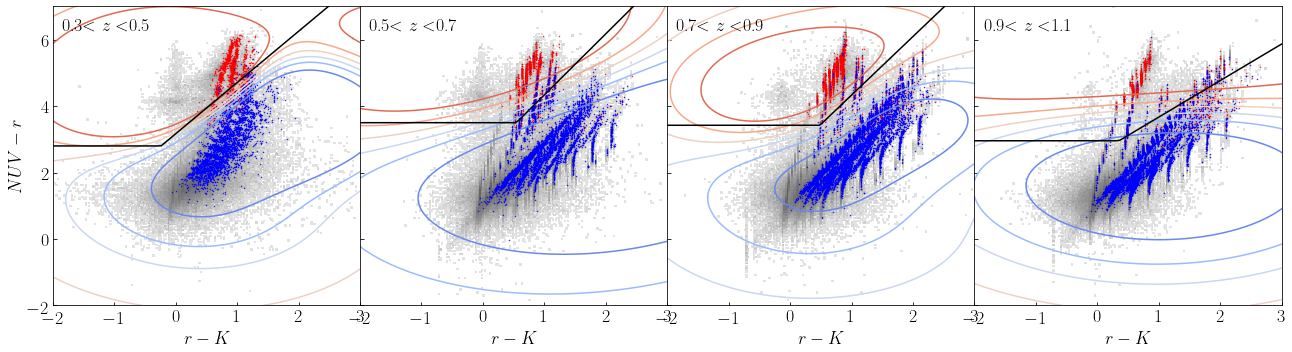

In [46]:
fig, axs = plt.subplots(1, 4, figsize=(18,5),sharex=True, sharey=True)
zs = [0.4, 0.6, 0.8, 1.0]
sfq_type='NUVrk'
# params_path = 'sfq_trained_params_old_6band_v3/'  # path to load the SVM and binary selection box parameters
# params_path = 'sfq_trained_params_inside_j_v10/'
# params_path = 'sfq_trained_params_new_6band_v10/' 
params_path = 'sfq_trained_params_6band_v11/' 
best_box = np.load(params_path+'best_select_box_one_mass_bin_NUVrk.npy')
print('params loaded from:',params_path)

for i in range(4):
    z = zs[i]
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_BEST']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']>9.5]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['Z_BEST']-cat_lv_gal_z['ZPDF'])<0.15]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['MASS_MED']-cat_lv_gal_z['MASS_MED_COSMOS'])<0.25]
    
    # load the whole catalog (test sample)
    cat_v6_gal_z = cat_v_gal[abs(cat_v_gal['Z_ML']-z)<0.1]
    cat_v6_gal_z = cat_v6_gal_z[cat_v6_gal_z['i']<26] 
    cat_v6_gal_z = cat_v6_gal_z[cat_v6_gal_z['i']>0]
    
    # plot the whole catalog
    axs[i].hist2d(cat_v6_gal_z['MAG_ABS_r'] - cat_v6_gal_z['MAG_ABS_Ks'], cat_v6_gal_z['MAG_ABS_NUV'] - cat_v6_gal_z['MAG_ABS_r'],
                         bins=200,range=[[-2,3],[-2,7]], vmin=0.1, vmax=10000,
                         norm=mpl.colors.LogNorm(), cmap='Greys')
    
    # Laigle+2016 NUVrK classification
    cat_lv_gal_z_sf = cat_lv_gal_z[cat_lv_gal_z['CLASS']==1]  #sf
    cat_lv_gal_z_q = cat_lv_gal_z[cat_lv_gal_z['CLASS']==0]  #q
    
    # Load trained SVM model from file
    with open(params_path+'pickle_svm_z_NUVrk_'+str(i+1)+'.pkl', 'rb') as file:
        clf_load = pickle.load(file)
    xx, yy = make_meshgrid(np.linspace(-1,3,100), np.linspace(-1,7,100))
    plot_contours(axs[i], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
    
    rk_draw = np.linspace(-2,3,100)
    nuv_draw_mid = gv_boundary_2(rk_draw,best_box[i][0],best_box[i][1],best_box[i][2])
    axs[i].plot(rk_draw, nuv_draw_mid, color='k')
    
#     NUVrK but with color-coding from COSMOS classification
    axs[i].scatter(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_Ks'], 
                          cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'],
                         s=0.2,c='r')
    axs[i].scatter(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_Ks'], 
                          cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'],
                         s=0.2,c='b')
    
    # plot only massive gals from v8 catalogs
#     cat_m = Table.read('clauds_cat_v2020/completeness_useful_params_cat/DEEP_deep_v8_gal_cut_params_sfq_added.fits')
#     cat_m = cat_m[abs(cat_m['ZPHOT']-z)<0.1]
#     cat_m = cat_m[cat_m['MASS_MED']>11.3]
#     cat_m = cat_m[cat_m['sfProb_nuvrk']>=0]
#     cat_m = cat_m[cat_m['sfProb_nuvrk']<=1]
    
#     cat_m_q = cat_m[cat_m['sfProb_nuvrk']<0.45]
#     cat_m_sf = cat_m[cat_m['sfProb_nuvrk']>=0.45]
    
#     axs[i].scatter(cat_m_q['MAG_ABS_r'] - cat_m_q['MAG_ABS_Ks'], 
#                          cat_m_q['MAG_ABS_NUV'] - cat_m_q['MAG_ABS_r'],
#                          s=1,c='r')
#     axs[i].scatter(cat_m_sf['MAG_ABS_r'] - cat_m_sf['MAG_ABS_Ks'], 
#                          cat_m_sf['MAG_ABS_NUV'] - cat_m_sf['MAG_ABS_r'],
#                          s=1,c='b')
    
    axs[i].annotate(str(round(z-0.1,1))+"$<z<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[i].set_xlabel(r'$r-K$',fontsize=18)

axs[0].set_ylabel(r'$NUV-r$',fontsize=18)
plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.savefig('figures/radial_dist/sfq_onemassbin.png',dpi=70)


NUVRz selection (single mass bin)

In [24]:
fig, axs = plt.subplots(1, 4, figsize=(18,5),sharex=True, sharey=True)
zs = [0.4, 0.6, 0.8, 1.0]
inset_type = 'ssfr'
best_box = np.load('best_select_box_one_mass_bin_NUVrz.npy')

# (in cat_lv_gal) _1 from COSMOS2015
# (in cat_lv_gal) _2 from CLAUDS/HSC COSMOS_uddd

for i in range(4):
    z = zs[i]
    cat_lv_gal_z = cat_lv_gal[abs(cat_lv_gal['Z_ML']-z)<0.1]
    cat_lv_gal_z = cat_lv_gal_z[cat_lv_gal_z['MASS_MED']>9.5]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['Z_ML']-cat_lv_gal_z['ZPDF'])<0.15]
    cat_lv_gal_z = cat_lv_gal_z[abs(cat_lv_gal_z['MASS_MED']-cat_lv_gal_z['MASS_MED_COSMOS'])<0.25]
    
    # load the whole catalog (test sample)
    cat_v6_gal_z = cat_v_gal[abs(cat_v_gal['Z_ML']-z)<0.1]
    cat_v6_gal_z = cat_v6_gal_z[cat_v6_gal_z['i']<26]
    cat_v6_gal_z = cat_v6_gal_z[cat_v6_gal_z['i']>0]
    
    # plot
    axs[i].hist2d(cat_v6_gal_z['MAG_ABS_r'] - cat_v6_gal_z['MAG_ABS_z'], 
                  cat_v6_gal_z['MAG_ABS_NUV'] - cat_v6_gal_z['MAG_ABS_r'],
                         bins=200,range=[[-1,2],[-1,6.5]], vmin=0.1, vmax=10000,
                         norm=mpl.colors.LogNorm(), cmap='Greys')
    
    # Laigle+2016 NUVrK classification
    cat_lv_gal_z_sf = cat_lv_gal_z[cat_lv_gal_z['CLASS']==1]  #sf
    cat_lv_gal_z_q = cat_lv_gal_z[cat_lv_gal_z['CLASS']==0]  #q
    
    # Load trained SVM model from file
    with open('pickle_svm_z_NUVrz_'+str(i)+'.pkl', 'rb') as file:
        clf_load = pickle.load(file)
    xx, yy = make_meshgrid(np.linspace(-1,3,100), np.linspace(-1,7,100))
    plot_contours(axs[i], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
    
    # binary selection box
    rz_draw = np.linspace(-2,3,100)
    nuv_draw_mid = gv_boundary_2(rz_draw,best_box[i][0],best_box[i][1],best_box[i][2])
    axs[i].plot(rz_draw, nuv_draw_mid, color='k')
    
    # NUVrz but with color-coding from Laigle+2016 NUVrK classification
    axs[i].scatter(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_z'], 
                          cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'],
                         s=0.2,c='b')
    axs[i].scatter(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_z'], 
                          cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'],
                         s=0.2,c='r')
    
    axs[i].annotate(str(round(z-0.1,1))+"$<z<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)
    axs[i].set_xlabel(r'$r-z$',fontsize=18)

plt.tight_layout()
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[0].set_ylabel(r'$NUV-r$',fontsize=18)


Text(146.27571411892902, 0.5, '$NUV-r$')

### Add sfProb/sfq info to the catalogs
Determine sf/q for all galaxies using all four sfq separation methods, and add the info to catalogs

sf = 1
q = 0

In [51]:
z_edges = [0.3, 0.5, 0.7, 0.9, 1.1, 1.5] # 6 redshift bins
gv_half_width = 0.25

# params_path = 'sfq_trained_params_old_6band_v3/'  # path to load the SVM and binary selection box parameters
# params_path = 'sfq_trained_params_inside_j_v10/'
# params_path = 'sfq_trained_params_new_6band_v10/'
params_path = 'sfq_trained_params_6band_v11/'

# for cat_name in ['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep']:
for cat_name in ['COSMOS_deep']:
    
#     cat_name_full = 'clauds_cat_v2020/completeness_useful_params_cat/'+cat_name+'_v9_gal_cut_params.fits'
#     cat_name_full = 'COSMOS2020_Laigle_Vincent_uddd_added.fits' # 6-band photometry catalog
#     cat_name_full = 'COSMOS2020_Laigle_Vincent_v10_added_inside_j.fits'
#     cat_name_full = 'COSMOS2020_Laigle_Vincent_v10_added_6B.fits'
    cat_name_full = 'COSMOS2020_Laigle_Vincent_v11_added_6B.fits'
#     cat_name_full = 'COSMOS2020_Laigle_Vincent_v9_added.fits'
    print(cat_name_full)
    
    
    cat = Table.read(cat_name_full)
    sfProb_nuvrz = []
    sfProb_nuvrk = []
    sfq_nuvrz = []
    sfq_nuvrk = []
    for i in tqdm(range(len(cat))):
        gal = cat[i]
        if abs(gal['MAG_ABS_r']) < 99. and abs(gal['MAG_ABS_z'])< 99. and abs(gal['MAG_ABS_Ks'])< 99. and gal['MAG_ABS_NUV']< 99. and abs(gal['MAG_ABS_r'])< 99.:
            rz = gal['MAG_ABS_r'] - gal['MAG_ABS_z']
            rk = gal['MAG_ABS_r'] - gal['MAG_ABS_Ks']
            nuvr = gal['MAG_ABS_NUV'] - gal['MAG_ABS_r']

            if gal['Z_BEST']>0 and gal['Z_BEST']<1.5:
                z_bin_index = -1
                for k,z_edge in enumerate(z_edges):
                    if gal['Z_BEST']<z_edge:
                        z_bin_index=k
                        break  
                
                # load classification
                with open(params_path+'pickle_svm_z_NUVrz_'+str(z_bin_index)+'.pkl', 'rb') as file:
                    clf_load_nuvrz = pickle.load(file)
                with open(params_path+'pickle_svm_z_NUVrk_'+str(z_bin_index)+'.pkl', 'rb') as file:
                    clf_load_nuvrk = pickle.load(file)
                    
                # load binary classifiers
                best_boxes_nuvrz = np.load(params_path+'best_select_box_one_mass_bin_NUVrz.npy')
                best_boxes_nuvrk = np.load(params_path+'best_select_box_one_mass_bin_NUVrk.npy')
                
                # add sfq classification info
                if z_bin_index>=0:
                    sfProb_nuvrz.append(clf_load_nuvrz.predict_proba(np.c_[rz,nuvr])[:,0][0])
                    sfProb_nuvrk.append(clf_load_nuvrk.predict_proba(np.c_[rk,nuvr])[:,0][0])
                    delta_gv_nuvrz = nuvr - gv_boundary_2(rz,best_boxes_nuvrz[z_bin_index][0],best_boxes_nuvrz[z_bin_index][1],best_boxes_nuvrz[z_bin_index][2])
                    delta_gv_nuvrk = nuvr - gv_boundary_2(rk,best_boxes_nuvrk[z_bin_index][0],best_boxes_nuvrk[z_bin_index][1],best_boxes_nuvrk[z_bin_index][2])
                    
                    #nuvrz
                    if delta_gv_nuvrz<-gv_half_width:
                        sfq_nuvrz.append(1.)
                    elif delta_gv_nuvrz<0:
                        sfq_nuvrz.append(0.51)
                    elif delta_gv_nuvrz<gv_half_width:
                        sfq_nuvrz.append(0.49)
                    else:
                        sfq_nuvrz.append(0.)
                    
                    # nuvrk
                    if delta_gv_nuvrk<-gv_half_width:
                        sfq_nuvrk.append(1.)
                    elif delta_gv_nuvrk<0:
                        sfq_nuvrk.append(0.51)
                    elif delta_gv_nuvrk<gv_half_width:
                        sfq_nuvrk.append(0.49)
                    else:
                        sfq_nuvrk.append(0.)
                else:
                    sfProb_nuvrz.append(-99.)
                    sfProb_nuvrk.append(-99.)
                    sfq_nuvrk.append(-99.)
                    sfq_nuvrz.append(-99.)
            else:
                sfProb_nuvrz.append(99.)
                sfProb_nuvrk.append(99.)
                sfq_nuvrk.append(99.)
                sfq_nuvrz.append(99.)
        else:
            sfProb_nuvrz.append(99.)
            sfProb_nuvrk.append(99.)
            sfq_nuvrk.append(99.)
            sfq_nuvrz.append(99.)
    
                                     
    # write into the catalog
    sfProb_col_nuvrz = Column(name='sfProb_nuvrz',data=sfProb_nuvrz) # 1=sf
    sfProb_col_nuvrk = Column(name='sfProb_nuvrk',data=sfProb_nuvrk) # 1=sf
    sfq_col_nuvrz = Column(name='sfq_nuvrz',data=sfq_nuvrz)  # 0=sf, 1=q
    sfq_col_nuvrk = Column(name='sfq_nuvrk',data=sfq_nuvrk)  # 0=sf, 1=q
    
    if 'sfProb_nuvrz' not in cat.keys():
        cat.add_columns([sfProb_col_nuvrz,sfProb_col_nuvrk,sfq_col_nuvrz,sfq_col_nuvrk])
    else:
        print('sfProb already exist.')
        cat.remove_columns(['sfProb_nuvrz','sfProb_nuvrk','sfq_nuvrz','sfq_nuvrk'])
        cat.add_columns([sfProb_col_nuvrz,sfProb_col_nuvrk,sfq_col_nuvrz,sfq_col_nuvrk])
    cat.write(cat_name_full.replace('.fits','_sfq_added.fits'),overwrite=True)
    print(cat_name_full.replace('.fits','_sfq_added.fits')+' written.')

COSMOS2020_Laigle_Vincent_v11_added_6B.fits


100%|██████████| 903131/903131 [12:39<00:00, 1189.39it/s]


COSMOS2020_Laigle_Vincent_v11_added_6B_sfq_added.fits written.


#### check  NUVrK consistent with SSFR_MED

In [30]:
cat = Table.read('clauds_cat_v2020/completeness_useful_params_cat/COSMOS_deep_v9_gal_cut_params_sfq_added.fits')
cat = cat[cat['inside_u'] == True]
cat = cat[cat['MASK'] == 0]  # unmasked
cat_gal = cat[cat['OBJ_TYPE'] == 0]  # galaxies

Text(0.13, 0.92, '$z=0.8$')

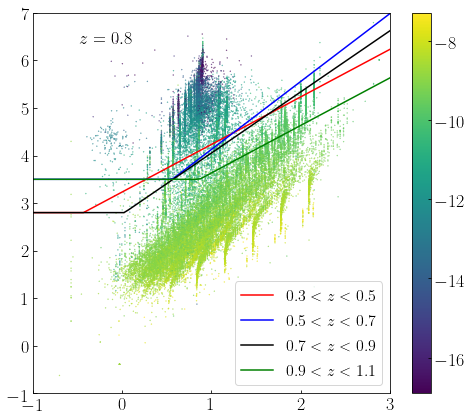

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(8,7))
z=0.8
# selection
cat_gal_all = cat_gal[cat_gal['MASS_MED']>9.5]
cat_gal_all = cat_gal_all[abs(cat_gal_all['ZPHOT']-z)<0.1]
im = plt.scatter(cat_gal_all['MAG_ABS_r']-cat_gal_all['MAG_ABS_Ks'],
                 cat_gal_all['MAG_ABS_NUV']-cat_gal_all['MAG_ABS_r'],
            s=0.1,c=cat_gal_all['SSFR_MED'])

best_box = np.load('best_select_box_one_mass_bin_NUVrk.npy')

rk_draw = np.linspace(-2,3,100)
nuv_draw_mid = gv_boundary_2(rk_draw,best_box[0][0],best_box[0][1],best_box[0][2])
plt.plot(rk_draw, nuv_draw_mid, color='r',label=r'$0.3<z<0.5$')

nuv_draw_mid = gv_boundary_2(rk_draw,best_box[1][0],best_box[1][1],best_box[1][2])
plt.plot(rk_draw, nuv_draw_mid, color='b',label=r'$0.5<z<0.7$')

nuv_draw_mid = gv_boundary_2(rk_draw,best_box[2][0],best_box[2][1],best_box[2][2])
plt.plot(rk_draw, nuv_draw_mid, color='k',label=r'$0.7<z<0.9$')

nuv_draw_mid = gv_boundary_2(rk_draw,best_box[3][0],best_box[3][1],best_box[3][2])
plt.plot(rk_draw, nuv_draw_mid, color='g',label=r'$0.9<z<1.1$')


cb_ax = fig.add_axes()
cbar = fig.colorbar(im, cax=cb_ax)
plt.legend(fontsize=16)
plt.xlim([-1,3])
plt.ylim([-1,7])
plt.annotate("$z="+str(z)+"$",xy=([0.13,0.92]),xycoords='axes fraction',fontsize=18)

161 662 0.19562575941676794


Text(0.13, 0.92, '$z=0.8$')

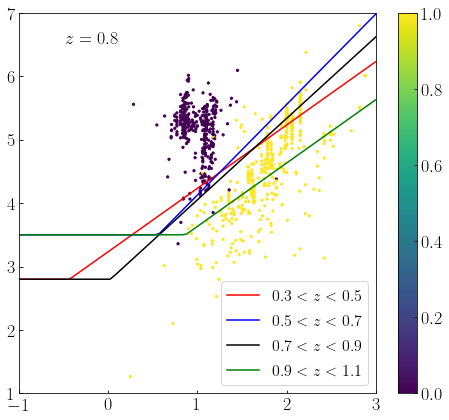

In [38]:
fig, axs = plt.subplots(1, 1, figsize=(8,7))
z = 0.8

# selection
cat_gal_massive = cat_gal[cat_gal['MASS_MED']>11.3] # only massive galaxies
cat_gal_massive = cat_gal_massive[abs(cat_gal_massive['ZPHOT']-z)<0.1]

num_cen_sf = len(cat_gal_massive[cat_gal_massive['sfq_nuvrk']>0.5])
num_cen = len(cat_gal_massive)
print(num_cen_sf,num_cen-num_cen_sf,num_cen_sf/num_cen)

im = plt.scatter(cat_gal_massive['MAG_ABS_r']-cat_gal_massive['MAG_ABS_Ks'],
                 cat_gal_massive['MAG_ABS_NUV']-cat_gal_massive['MAG_ABS_r'],
            s=5,c=cat_gal_massive['SSFR_MED']>-11)

best_box = np.load('best_select_box_one_mass_bin_NUVrk.npy')

rk_draw = np.linspace(-2,3,100)
nuv_draw_mid = gv_boundary_2(rk_draw,best_box[0][0],best_box[0][1],best_box[0][2])
plt.plot(rk_draw, nuv_draw_mid, color='r',label=r'$0.3<z<0.5$')

nuv_draw_mid = gv_boundary_2(rk_draw,best_box[1][0],best_box[1][1],best_box[1][2])
plt.plot(rk_draw, nuv_draw_mid, color='b',label=r'$0.5<z<0.7$')

nuv_draw_mid = gv_boundary_2(rk_draw,best_box[2][0],best_box[2][1],best_box[2][2])
plt.plot(rk_draw, nuv_draw_mid, color='k',label=r'$0.7<z<0.9$')

nuv_draw_mid = gv_boundary_2(rk_draw,best_box[3][0],best_box[3][1],best_box[3][2])
plt.plot(rk_draw, nuv_draw_mid, color='g',label=r'$0.9<z<1.1$')

cb_ax = fig.add_axes()
cbar = fig.colorbar(im, cax=cb_ax)
plt.legend(fontsize=16)
plt.xlim([-1,3])
plt.ylim([1,7])
plt.annotate("$z="+str(z)+"$",xy=([0.13,0.92]),xycoords='axes fraction',fontsize=18)

#### centrals NUVrK plot compare fields

In [3]:
cat_m = Table.read('/Volumes/LejaySSD/v8_cats/DEEP_deep_v8_v210116.fits')

Text(0, 0.5, '$NUV-r$')

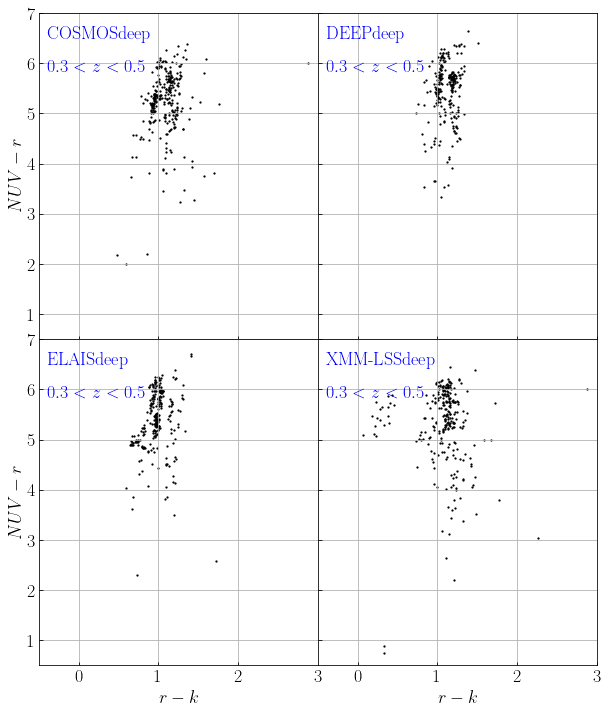

In [9]:
fig, axs = plt.subplots(2, 2, figsize=(10,12),sharex=True, sharey=True)

z=0.4
for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep']):
    cat_m = Table.read('/Volumes/LejaySSD/v9_cats/'+cat_name+'_v9.fits')
    cat_m = cat_m[cat_m['FLAG_FIELD_BINARY'][:,0]==True]
    cat_m = cat_m[cat_m['MASK']==0]
    cat_m = cat_m[cat_m['OBJ_TYPE']==0]
    if cat_name == 'XMM-LSS_deep':
        cat_m = cat_m[cat_m['FLAG_FIELD_BINARY'][:,2]==True]
    else:
        cat_m = cat_m[cat_m['FLAG_FIELD_BINARY'][:,1]==True]
    cat_m = cat_m[abs(cat_m['ZPHOT']-z)<0.1]
    cat_m = cat_m[cat_m['MASS_MED']>11.3]
    
    row = i //2
    col = i % 2
    axs[row][col].scatter(cat_m['MAG_ABS_r'] - cat_m['MAG_ABS_Ks'], cat_m['MAG_ABS_NUV'] - cat_m['MAG_ABS_r'],
                          s=1.5,c='k')
    axs[row][col].set_xlim([-0.5,3])
    axs[row][col].set_ylim([0.5,7])
    axs[row][col].annotate(cat_name.replace('_',''),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18,color='b')
    axs[row][col].annotate(r'$'+str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1))+'$',xy=([0.03,0.82]),xycoords='axes fraction',fontsize=18,color='b')
    axs[row][col].grid()
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[1][0].set_xlabel(r'$r-k$',fontsize=18)
axs[1][1].set_xlabel(r'$r-k$',fontsize=18)
axs[0][0].set_ylabel(r'$NUV-r$',fontsize=18)
axs[1][0].set_ylabel(r'$NUV-r$',fontsize=18)


### NUVrz (rk) for centrals only

In [35]:
# training of SVM and binary selection box
zs = [0.4, 0.6, 0.8]
diagram_type = 'nuvrk'

best_box = []
for i in range():
    z = zs[i]
    z = zs[i]
    central_shiraz_added_z = Table.read('CUT_deep_catalogs/radial_dist_code/central_cat/isolated_COSMOS_deep_11.15_'+str(z)+'_central_SHIRAZ_added.fits')

    print(z,len(central_shiraz_added_z))
    central_shiraz_added_z = central_shiraz_added_z[~np.isnan(central_shiraz_added_z['MAG_APER_CH2'])]
    central_shiraz_added_z = central_shiraz_added_z[~np.isnan(central_shiraz_added_z['MAG_APER_CH1'])]
    central_shiraz_added_z = central_shiraz_added_z[~np.isnan(central_shiraz_added_z['MAG_ABS_z'])]
    central_shiraz_added_z = central_shiraz_added_z[~np.isnan(central_shiraz_added_z['MAG_ABS_r'])]
    central_shiraz_added_z = central_shiraz_added_z[~np.isnan(central_shiraz_added_z['MAG_ABS_NUV'])]
    central_shiraz_added_z = central_shiraz_added_z[~np.isnan(central_shiraz_added_z['z'])]
    central_shiraz_added_z = central_shiraz_added_z[~np.isnan(central_shiraz_added_z['r'])]
    print(z,len(central_shiraz_added_z))
    
    if diagram_type=='nuvrk':
        color1 = central_shiraz_added_z['MAG_ABS_r'] - central_shiraz_added_z['MAG_ABS_Ks']
    elif diagram_type=='nuvrz':
        color1 = central_shiraz_added_z['MAG_ABS_r'] - central_shiraz_added_z['MAG_ABS_z']
    nuvr = central_shiraz_added_z['MAG_ABS_NUV'] - central_shiraz_added_z['MAG_ABS_r']
    x=np.c_[np.array(color1),np.array(nuvr)]  # nuv r k/z colors as inputs
    y=central_shiraz_added_z['CLASS']==0  # COSMOS2020 training labels
    
    # 5-fold CV for best hyperparameter gamma and C
    svm_cv=GridSearchCV(svm.SVC(kernel='rbf'),{'gamma': np.linspace(0.1, 0.3, 50), 'C' : np.linspace(0.02,0.5,50)}, 
                    scoring={'AUC': 'roc_auc'}, refit='AUC', cv = 5, return_train_score=True)
    
    random_ids = np.random.randint(low=0,high=len(central_shiraz_added_z),size=100)
    svm_cv.fit(x[random_ids],y[random_ids])
    gamma = svm_cv.best_params_['gamma']
    C = svm_cv.best_params_['C']
    print('gamma=%.3f, C=%.3f, mean AUC of best model: %.3f' % (gamma,C,svm_cv.best_score_))
    
    # train the SVM model
    clf = svm.SVC(kernel='rbf', gamma=gamma, C=C,  probability=True)   # the svm classifier
    clf.fit(x, y)

    # save the SVM estimator through pickle
    pkl_filename = 'pickle_svm_central_'+diagram_type+'_'+str(i)+'.pkl'
    with open(pkl_filename, 'wb') as file:
        pickle.dump(clf, file)
        
    # train the binary selection box
    scores = []
    fcs = []
    fms = []
    for i in range(len(ic_1_mesh.ravel())):
        fc,fm,score = fraction_score(central_shiraz_added_z, ic_1_mesh.ravel()[i], ic_2_mesh.ravel()[i],
                                           slope_mesh.ravel()[i],diagram_type=diagram_type)
        if score >= 0:
            scores.append(score)
            fcs.append(fc)
            fms.append(fm)
        else:
            scores.append(999.)
    
    # best parameters
    best_id = np.argmin(np.array(scores))
    ic_1,ic_2,slope = ic_1_mesh.ravel()[best_id], ic_2_mesh.ravel()[best_id], slope_mesh.ravel()[best_id]
    best_box.append([ic_1,ic_2,slope])
    print(i,best_id,[ic_1,ic_2,slope])
    print(fcs[best_id],fms[best_id])
    print(' ')
    

    np.save('best_select_box_central_'+diagram_type+'_one_mass_bin.npy',np.array(best_box))

FileNotFoundError: [Errno 2] No such file or directory: 'CUT_deep_catalogs/radial_dist_code/central_cat/isolated_COSMOS_deep_11.15_0.2_central_SHIRAZ_added.fits'

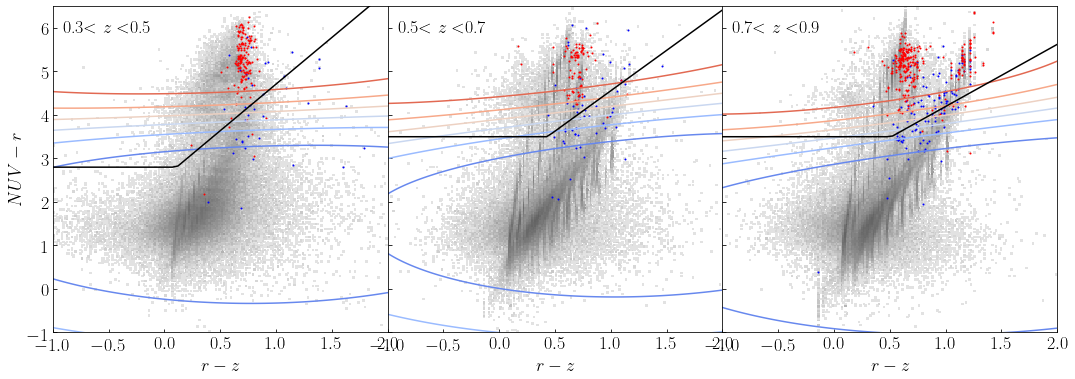

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(18,6),sharex=True, sharey=True)

zs = [0.4, 0.6, 0.8]
inset_type = 'ssfr'
best_box = np.load('best_select_box_central_nuvrz_one_mass_bin.npy')
cat_name = 'COSMOS_deep'

for i in range(3):
    z = zs[i]
    
    # laod the central catalog
    cat_lv_gal_z = Table.read('CUT_deep_catalogs/radial_dist_code/central_cat/isolated_'+\
                                 cat_name+'_11.15_'+str(z)+'_central_SHIRAZ_added.fits')
    
    # load the whole catalog (test sample)
    cat_v6_gal_z = cat_v_gal[abs(cat_v_gal['Z_ML']-z)<0.1]
    
    # magnitude cut
    cat_v6_gal_z = cat_v6_gal_z[cat_v6_gal_z['i']<26]
    cat_v6_gal_z = cat_v6_gal_z[cat_v6_gal_z['i']>0]
    
    # plot
    axs[i].hist2d(cat_v6_gal_z['MAG_ABS_r'] - cat_v6_gal_z['MAG_ABS_z'], 
                  cat_v6_gal_z['MAG_ABS_NUV'] - cat_v6_gal_z['MAG_ABS_r'],
                         bins=200,range=[[-1,2],[-1,6.5]], vmin=0.1, vmax=10000,
                         norm=mpl.colors.LogNorm(), cmap='Greys')
    
    # Laigle+2016 NUVrK classification
    cat_lv_gal_z_sf = cat_lv_gal_z[cat_lv_gal_z['CLASS']==1]  #sf
    cat_lv_gal_z_q = cat_lv_gal_z[cat_lv_gal_z['CLASS']==0]  #q
    
    # Load trained SVM model from file
    with open('pickle_svm_z_NUVrz_'+str(i)+'.pkl', 'rb') as file:
        clf_load = pickle.load(file)
    xx, yy = make_meshgrid(np.linspace(-1,3,100), np.linspace(-1,7,100))
    plot_contours(axs[i], clf_load, xx, yy, cmap=plt.cm.coolwarm_r)
    
    # binary selection box
    rz_draw = np.linspace(-2,3,100)
    nuv_draw_mid = gv_boundary_2(rz_draw,best_box[i][0],best_box[i][1],best_box[i][2])
    axs[i].plot(rz_draw, nuv_draw_mid, color='k')
    
    # NUVrz but with color-coding from Laigle+2016 NUVrK classification
    axs[i].scatter(cat_lv_gal_z_sf['MAG_ABS_r'] - cat_lv_gal_z_sf['MAG_ABS_z'], 
                          cat_lv_gal_z_sf['MAG_ABS_NUV'] - cat_lv_gal_z_sf['MAG_ABS_r'],
                         s=1,c='b')
    axs[i].scatter(cat_lv_gal_z_q['MAG_ABS_r'] - cat_lv_gal_z_q['MAG_ABS_z'], 
                          cat_lv_gal_z_q['MAG_ABS_NUV'] - cat_lv_gal_z_q['MAG_ABS_r'],
                         s=1,c='r')
    
    axs[i].annotate(str(round(z-0.1,1))+"$<z<$"+str(round(z+0.1,1)),xy=([0.03,0.92]),xycoords='axes fraction',fontsize=18)

fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
axs[0].set_xlabel(r'$r-z$',fontsize=18)
axs[1].set_xlabel(r'$r-z$',fontsize=18)
axs[2].set_xlabel(r'$r-z$',fontsize=18)
axs[0].set_ylabel(r'$NUV-r$',fontsize=18)
plt.savefig('/Users/lejay/Desktop/central_nuvrz.png')


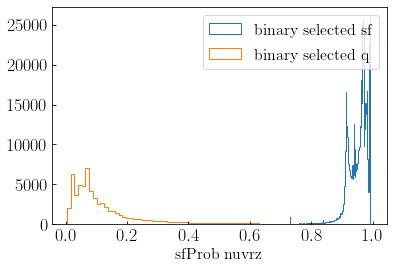

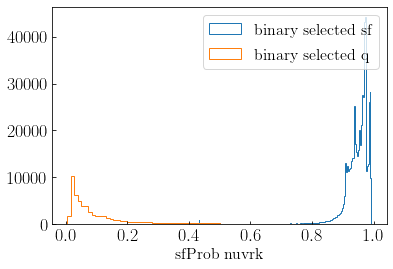

In [98]:
# read table
cat = Table.read('clauds_cat_v2020/completeness_useful_params_cat/ELAIS_deep_v9_gal_cut_params_sfq_added.fits')
# sfq_nuvrz separation
cat_sf = cat[cat['sfq_nuvrz']==1]
cat_q = cat[cat['sfq_nuvrz']==0]

# plot the histogram
plt.hist(cat_sf['sfProb_nuvrz'],histtype='step',bins='scott',label='binary selected sf')
plt.hist(cat_q['sfProb_nuvrz'],histtype='step',bins='scott',label='binary selected q')
plt.xlabel('sfProb nuvrz',fontsize=16)
plt.legend(fontsize=16)
plt.show()

cat_sf = cat[cat['sfq_nuvrk']==1]
cat_q = cat[cat['sfq_nuvrk']==0]

# plot the histogram
plt.hist(cat_sf['sfProb_nuvrk'],histtype='step',bins='scott',label='binary selected sf')
plt.hist(cat_q['sfProb_nuvrk'],histtype='step',bins='scott',label='binary selected q')
plt.xlabel('sfProb nuvrk',fontsize=16)
plt.legend(fontsize=16)
plt.show()

### mass/z distribution

In [7]:
# redshift cut
z_low=0.3
z_high=0.5

cat_zcut_a = cat_a_gal[abs(cat_a_gal['zKDEPeak']-(z_high+z_low)/2)<(z_high-z_low)/2]
cat_zcut_t = cat_t_gal[abs(cat_t_gal['Z_BEST_BC03']-(z_high+z_low)/2)<(z_high-z_low)/2]
cat_zcut_v = cat_v_gal[abs(cat_v_gal['Z_ML']-(z_high+z_low)/2)<(z_high-z_low)/2]

print(cat_name)
print('after z cut', len(cat_zcut_a),len(cat_zcut_t),len(cat_zcut_v))

after z cut 292068 127637 323845


In [9]:
# mass cuts
m_low=11.15
m_high=13.0

cat_central_a = cat_zcut_a[abs(cat_zcut_a['MASS_MED']-(m_high+m_low)/2)<(m_high-m_low)/2]
cat_central_t = cat_zcut_t[abs(cat_zcut_t['MASS_MED']-(m_high+m_low)/2)<(m_high-m_low)/2]
cat_central_v = cat_zcut_v[abs(cat_zcut_v['MASS_MED']-(m_high+m_low)/2)<(m_high-m_low)/2]

print(cat_name)
print('massive gals',len(cat_central_a),len(cat_central_t),len(cat_central_v))

COSMOS_deep
massive gals 353 970 641


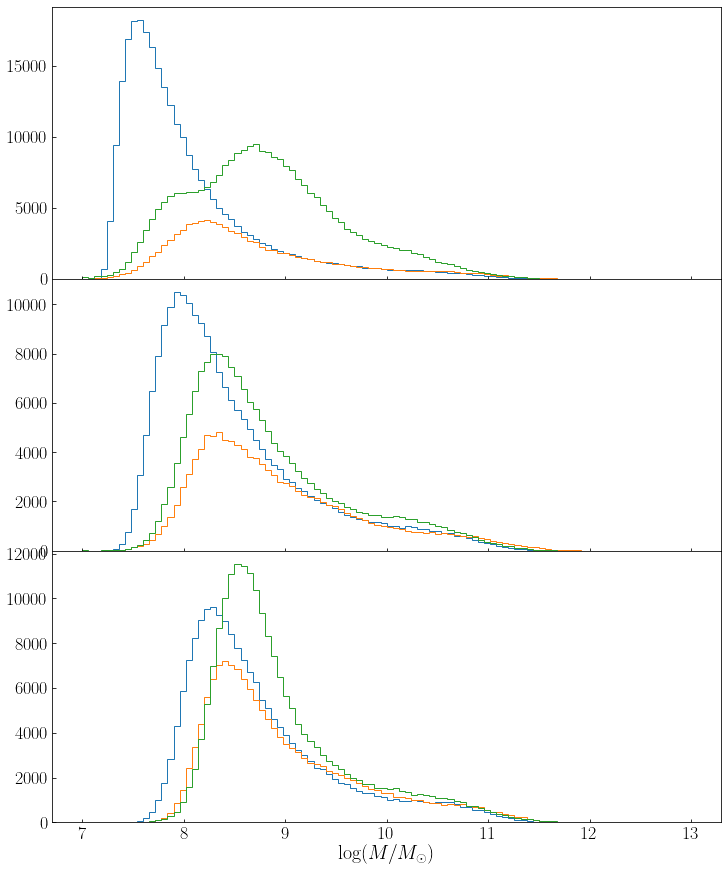

In [56]:
fig, axs = plt.subplots(3, 1, figsize=(12,15),sharex=True)

for i,z in enumerate([0.4,0.6,0.8]):
    cat_a_gal_z = cat_a_gal[abs(cat_a_gal['zKDEPeak']-z)<0.1]
    cat_t_gal_z = cat_t_gal[abs(cat_t_gal['Z_BEST_BC03']-z)<0.1]
    cat_v_gal_z = cat_v_gal[abs(cat_v_gal['Z_ML']-z)<0.1]
    
    axs[i].hist(cat_a_gal_z['MASS_MED'],bins=100, range=[7,13],histtype='step')
    axs[i].hist(cat_t_gal_z['MASS_MED'],bins=100, range=[7,13],histtype='step')
    axs[i].hist(cat_v_gal_z['MASS_MED'],bins=100, range=[7,13],histtype='step')
    
fig.subplots_adjust(hspace=0)
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=20)
plt.show()

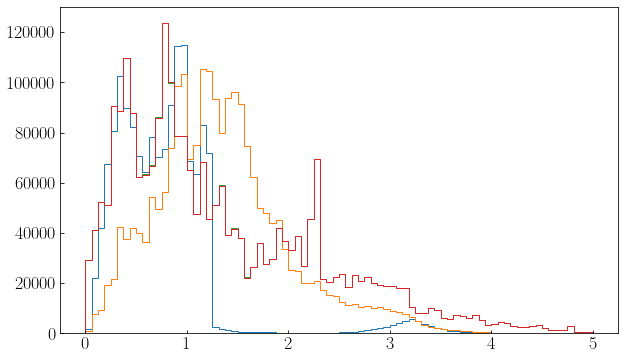

In [15]:
fig = plt.figure(figsize=(10,6))

plt.hist(cat_a_gal['zKDEPeak'],bins=80, range=[0,5],histtype='step')
plt.hist(cat_t_gal['Z_BEST_BC03'],bins=80, range=[0,5],histtype='step')
plt.hist(cat_v_gal['Z_ML'],bins=80, range=[0,5],histtype='step')
plt.hist(cat_v4_gal['Z_ML'],bins=80, range=[0,5],histtype='step')
plt.show()

### compare with bagpipes parameters

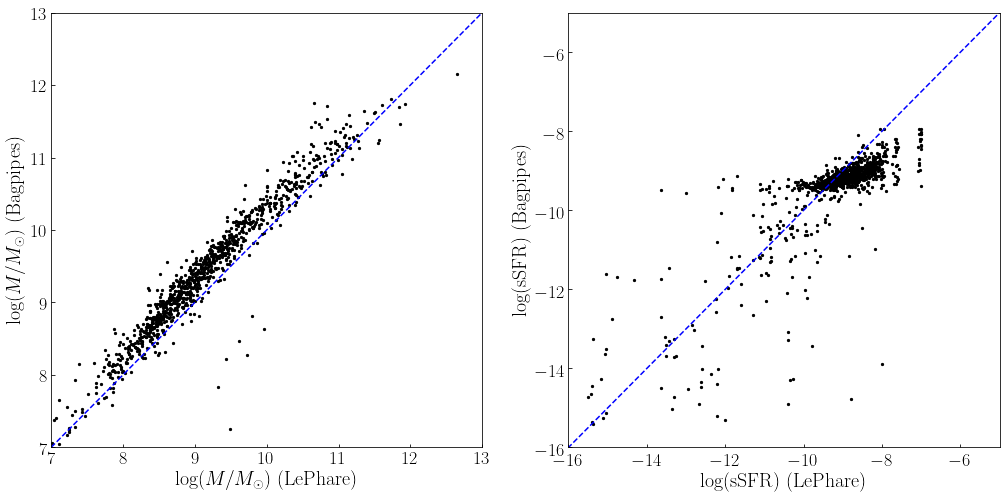

In [23]:
cat_v2020_pipes_added = Table.read('clauds_cat_v2020/COSMOS_deep_pipes_added_rand1000.fits')

m = cat_v2020_pipes_added['MASS_MED']
m_pipes = cat_v2020_pipes_added['stellar_mass_50']

ssfr = cat_v2020_pipes_added['SSFR_MED']
ssfr_pipes = cat_v2020_pipes_added['ssfr_50']


fig, axs = plt.subplots(1, 2, figsize=(17,8))

# mass
axs[0].scatter(m,m_pipes,c='k',s=5)

axs[0].set_xlabel(r'$\log(M/M_\odot)$ (LePhare)', fontsize=20)
axs[0].set_ylabel(r'$\log(M/M_\odot)$ (Bagpipes)', fontsize=20)
axs[0].set_xlim([7,13])
axs[0].set_ylim([7,13])
axs[0].plot([7,13],[7,13],color='b',linestyle='--')

#ssfr
axs[1].scatter(ssfr,ssfr_pipes,c='k',s=5)
axs[1].set_xlabel(r'$\log$(sSFR) (LePhare)', fontsize=20)
axs[1].set_ylabel(r'$\log$(sSFR) (Bagpipes)', fontsize=20)
axs[1].set_xlim([-16,-5])
axs[1].set_ylim([-16,-5])
axs[1].plot([-20,0],[-20,0],color='b',linestyle='--')

plt.show()

In [32]:
cat = Table.read('CUT_deep_catalogs/DEEP_deep_v1v2.fits')
cat_v2detected = cat[cat['i_1']>0]

In [43]:
#1-v2 , 2-v1
bins = np.linspace(7,13,100)

mass_hist_all, bin_edges = np.histogram(np.array(cat['MASS_MED_1']),range=(7,13),bins=bins)
mass_hist_v2detected, bin_edges = np.histogram(np.array(cat_v2detected['MASS_MED_1']),range=(7,13),bins=bins)

In [7]:
fig, axs = plt.subplots(2, 2, figsize=(14,10),sharex=True)

for i,cat_name in enumerate(['COSMOS_deep','DEEP_deep','ELAIS_deep','XMM-LSS_deep']):
    # 1) Anneya's catalog
    cat_a = Table.read('CUT_deep_catalogs/s16a_'+cat_name+'_masterCat.fits')
    cat_a_unmask = cat_a
    cat_a_inside = cat_a_unmask[cat_a_unmask['inside']==True]
    cat_a_gal = cat_a_inside[cat_a_inside['preds_median']<0.89]

    # # 3) Vincent's catalog
    cat_v = Table.read('clauds_cat_v2020/'+cat_name+'_v2_v200930.fits')
    cat_v_unmask = cat_v[cat_v['MASK']==0]
    if cat_name =='XMM-LSS_deep':
        cat_v_inside = cat_v_unmask[cat_v_unmask['FLAG_FIELD_BINARY'][:,2]==True]
    else:
        cat_v_inside = cat_v_unmask[cat_v_unmask['FLAG_FIELD_BINARY'][:,1]==True]
        
    cat_v_gal = cat_v_inside[cat_v_inside['OBJ_TYPE'] == 0]
    
    row = i//2
    col = i%2
    axs[row][col].hist(cat_a_gal['MASS_MED'],bins=100, range=[7,13],histtype='step')
    axs[row][col].hist(cat_v_gal['MASS_MED'],bins=100, range=[7,13],histtype='step')
    
fig.subplots_adjust(hspace=0)
fig.subplots_adjust(wspace=0)
plt.xlabel(r'$\log(M/M_\odot)$',fontsize=20)
plt.show()